<div style="text-align:center"> <span style="color:Black; font-size:3.4em;"> Time series forecasting<span></div>
<h2 align='center'>Part 1: Econometric methods</h2>
<h3 align='center'>Beginner - Intermediate level</h3>
<h4 align='center'>Author: Enes Zvornicanin</h4>

# Introduction

<span style="font-family: Arial;font-size:1.1em"> The purpose of this notebook is to provide a simple and clear theoretical explanation and minimal working example of the several models for time series forecasting. <u>Note: The main goal is not to have the best possible prediction on this particular dataset but to list and describe some of the algorithms for times series forecasting.</u> Thus, in this notebook, using some of the methods to predict monthly sales may not make much sense and they are provided as an example.

<span style="font-family: Arial;font-size:1.1em">Prior knowledge: Pandas and basics about time series. Also, some great notebooks as [Topic 9. Part 1. Time series analysis in Python](https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python) by Dmitriy Sergeyev and [Time Series I || An Introductory Start](https://www.kaggle.com/janiobachmann/time-series-i-an-introductory-start?scriptVersionId=53165252) by Janio Martinez Bachmann may provide additional explanation of some terms.

<div style="font-family: Arial;font-size:1.3em;background:rgb(255, 204, 0);color:black">
Feel free to contact me by commenting or message me in private if you need a more detailed explanation of some part of this work. <br><b>If you like this notebook and found it useful, please give an upvote.</b> 🙏 🔝<br>Also, feel free to share your criticisms or point me for my mistakes. It would help me a lot to improve my knowledge. <br>
After all, I have plans to write more about this theme so feel free to share your ideas in the comment section.
</div>

# Content

* [Autocorrelation (ACF)](#topic7)
* [Partial Autocorrelation (PACF)](#topic8)
* [Stationarity](#topic9)
  * [Augmented Dickey-Fuller Test (ADF)](#topic9.1)
  * [Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS)](#topic9.2)
* [Naive model](#topic1)
* [Simple rolling mean (simple moving average)](#topic2)
* [Weighted average](#topic3)
* [Simple exponential smoothing (SES)](#topic4)
* [Double exponential smoothing (Holt's exponential smoothing)](#topic5)
* [Triple exponential smoothing (Holt Winter’s Exponential Smoothing)](#topic6)
* [Autoregressive Model (AR)](#topic10)
  * [Akaike Information Critera (AIC) and Bayesian Information Critera (BIC)](#topic10.1)
* [Moving Average Model (MA)](#topic11)
* [Autoregressive Moving Average Model (ARMA)](#topic12)
* [Autoregressive Integrated Moving Average Model (ARIMA)](#topic13)
* [Seasonal Autoregressive Integrated Moving Average Model (SARIMA)](#topic14)
* [Seasonal Autoregressive Integrated Moving Average Model with Exogenous Regressors (SARIMAX)](#topic15)
* [Vector Autoregression Model (VAR)](#topic16)
  * [Cointegration](#topic16.1)
  * [Vector Error Correction Model (VECM)](#topic17)
  * [VAR example](#topic16.2)
  * [VECM example](#topic16.3)
* [Vector Autoregression Moving Average Model (VARMA)](#topic18)
* [Vector Autoregression Moving Average with Exogenous Regressors Model (VARMAX)](#topic19)

# Data preparation

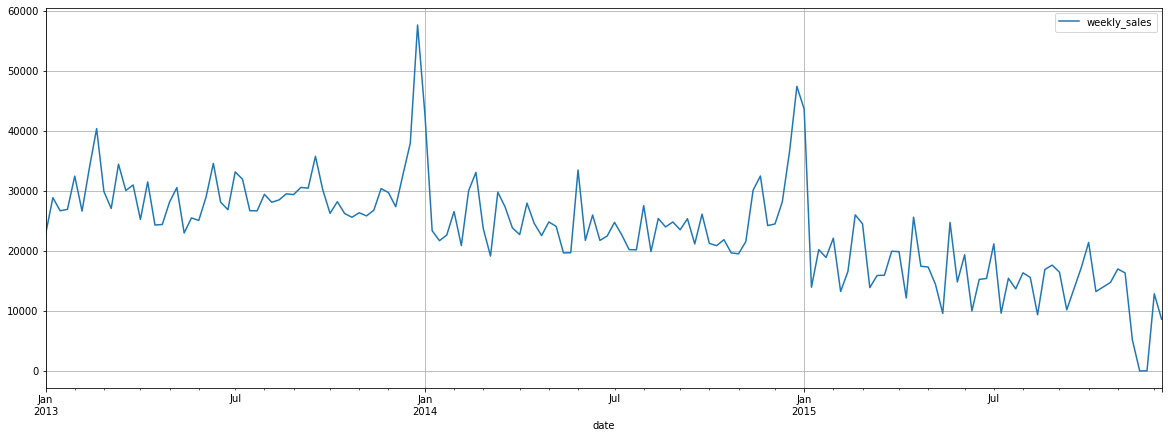

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (20,7)

data_dir = '/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv'

df = pd.read_csv(data_dir)
df = df[['date', 'item_cnt_day']]
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# group data by weekly sales
df_data = df.groupby(pd.Grouper(freq='W')).sum()
df_data = df_data.rename(columns = {'item_cnt_day': 'weekly_sales'})
df_data.plot()
plt.grid()

<a id =topic7> </a>
# Autocorrelation (ACF)


<div><span style="font-family: Arial;font-size:1.1em">Just a <b>simple Pearson correlation</b> between time series and a lagged version of itself.<br><br>
Blue bars on an ACF plot below are the error bands and anything within these bars is not statistically significant. It means that correlation values outside of this area are very likely a correlation and not a statistical fluke. The confidence interval is set to 95% by default.<br><br>
Notice that for a lag 0, ACF is always 1.<span></div>

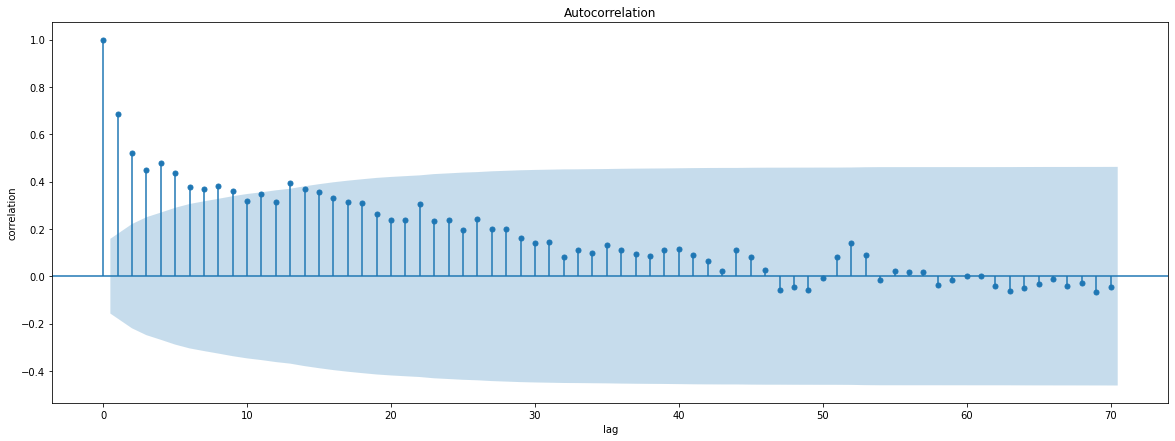

In [2]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)

acf_plot = plot_acf(df_data['weekly_sales'].values, lags = 70)
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

<a id =topic8> </a> 
# Partial Autocorrelation (PACF)

<div><span style="font-family: Arial;font-size:1.1em"><b>"Direct" correlation</b> between time series and a lagged version of itself.<br><br> 

For example, let's consider ACF of a signal S with a lag of 2. When we calculate correlation between $S_{t-2}$ and $S_{t}$, it includes both direct influence of $S_{t-2}$ to $S_{t}$ but also indirect through $S_{t-1}$ (all the arrows from the image). What we really want to calculate with PACF is the only direct effect of $S_{t-2}$ to $S_{t}$ without any undirect components.<br><br>

PACF of a signal $S$ with a lag 2 is calculated from regression model<span></div>
<span style="font-family: Arial;font-size:1.1em">$$S_{t} = \phi_{21}S_{t-1} + \phi_{22}S_{t-2} + \epsilon_{t},$$   
<span style="font-family: Arial;font-size:1.1em">using the coefficient $\phi_{22}$ as a value for PACF.

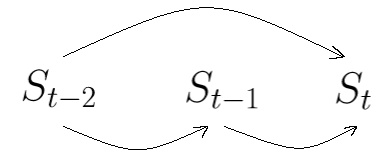

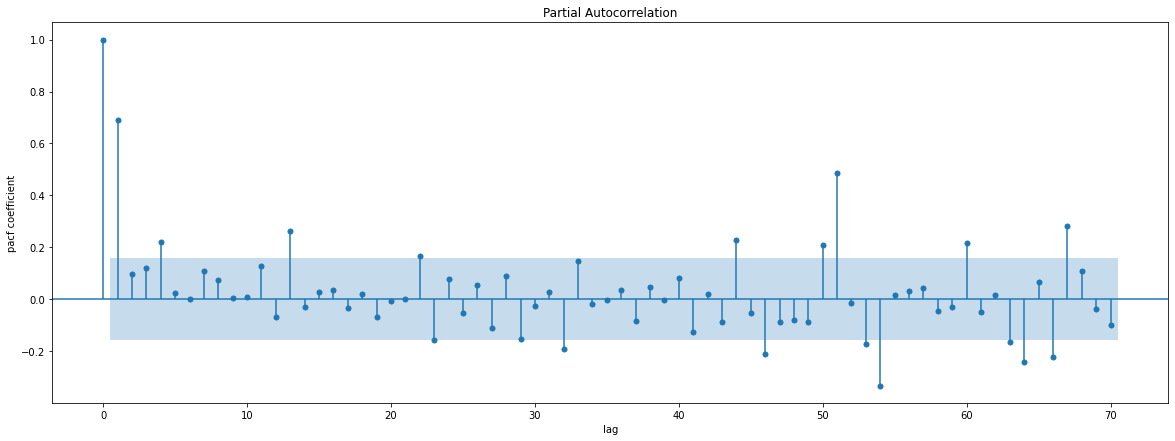

In [3]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)

acf_plot = plot_pacf(df_data['weekly_sales'].values, lags = 70)
plt.xlabel('lag')
plt.ylabel('pacf coefficient')
plt.show()

<a id =topic9> </a>
# Stationarity

<div><span style="font-family: Arial;font-size:1.1em">When it comes to time series forecasting, the stationarity of a time series is one of the most important conditions that the majority of algorithms require. Briefly, time series $S_{t}$ is stationary (weak stationarity) if these conditions are met:<br><br>
1. $S_{t}$ has a constant mean,<br>
2. $S_{t}$ has a constant standard deviation,<br>
3. There is no seasonality in $S_{t}.$ If $S_{t}$ has a repeating pattern within a year, then it has seasonality.<br><br>

The stationarity of the signal can be checked visually (approximation) or using some statistical hypothesis for a more precise answer. For that purpose, we will use 2 tests:
<a id =topic9.1> </a>
* **Augmented Dickey-Fuller Test (ADF)**

Null hypothesis: The signal is non-stationary.

If the p-value of this test is less than a critical value (for example 0.05), then we reject a null hypothesis. It means that signal is stationary
<a id =topic9.2> </a>
* **Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS)**

Null hypothesis: The signal is stationary.

If the p-value is less than 0.05, then we reject a null hypothesis. It means that signal is non-stationary<br><br>

If signal $S_{t}$ is non-stationary, we can <b>convert them into stationary</b> signal $T_{t}$ by differencing $$T_{t} = S_{t} - S_{t-1},$$ or calculating percent of change $$T_{t} =\frac{S_{t} - S_{t-1}}{S_{t-1}}.$$

Note: After these transformations, signal $T_{t}$ won't always be stationary. It is rare but can happen. In that case, if $T_{t}$ stays non-stationary, you can apply the same transformation to signal $T_{t}$. 

Also, it is worth mentioning that the stationary time series has an order of integration 0 (I(0)). If the time series is non-stationary and if after one difference becomes stationary, then it has an order of integration 1 (I(1)). Thus, non-stationary time series that can be transformed into stationary by $d$ successive differences, has an order of integration d (I(d)).

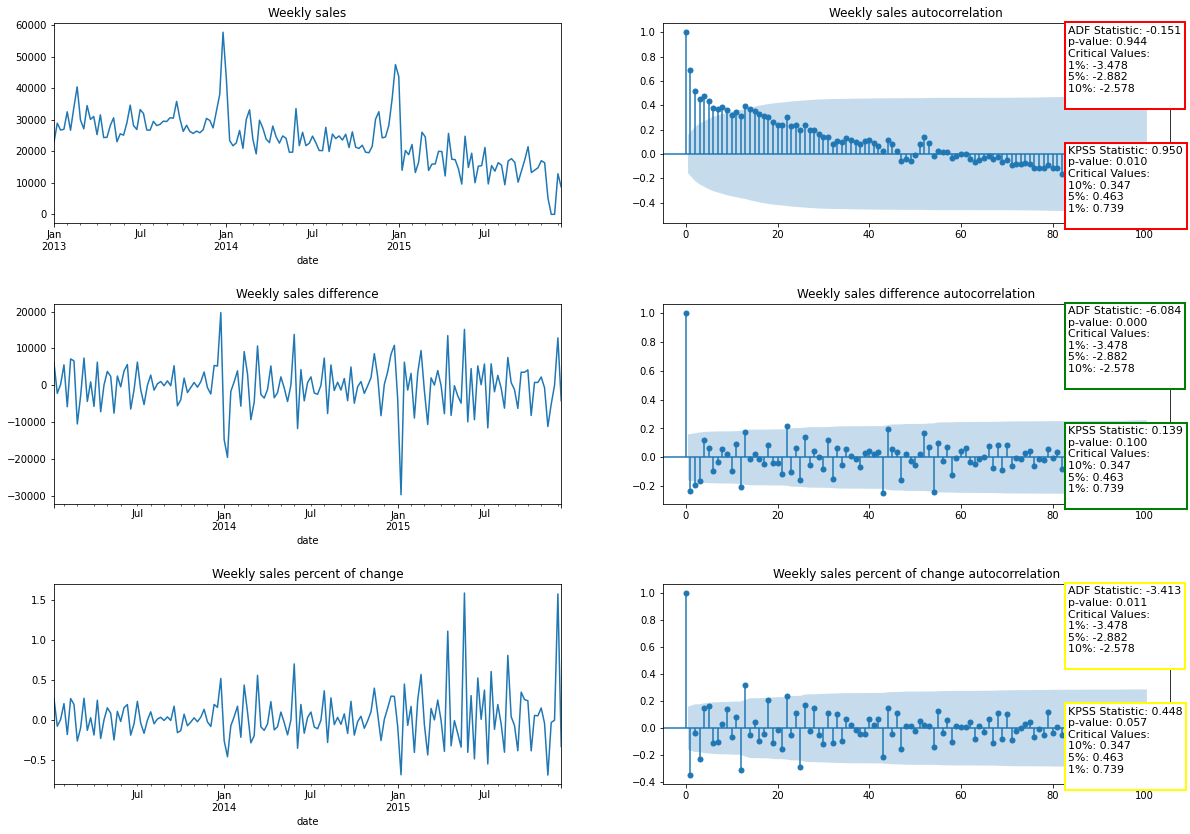

In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf

def adf_stat(time_series):
    """
    Run the augmented Dickey-Fuller test on a time series
    to determine if it's stationary.
    Arguments: 
        time_series: series. Time series that we want to test 
    Outputs: 
        Test statistics for the Augmented Dickey Fuller test in 
        the console 
        
    Null hypothesis: Signal is non-stationary
    
    if ADF Statistic > critical values then we cannot reject null hypothesis (signal is non-stationary)
    if ADF Statistic p < critical values then signal is stationary (based on significance)
    """
    result = adfuller(time_series.values)
    s = ''
    s+= 'ADF Statistic: %.3f\n' % result[0]
    s+= 'p-value: %.3f\n' % result[1]
    s+= 'Critical Values:\n'
    for key, value in result[4].items():
        s += '%s: %.3f\n' % (key, value)
    
    if result[0] < result[4]['1%']:
        stationarity = 1
    elif result[4]['1%'] <= result[0] and result[0] <= result[4]['10%']:
        stationarity = 2
    else:
        stationarity = 0
    
    return s, stationarity
def kpss_stat(time_series):
    """
    Kwiatkowski-Phillips-Schmidt-Shin test for stationarity.

    Computes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null hypothesis that x is level or trend stationary.
    """
    import warnings
    warnings.filterwarnings("ignore")
    
    result = kpss(time_series.values)
    s = ''
    s+= 'KPSS Statistic: %.3f\n' % result[0]
    s+= 'p-value: %.3f\n' % result[1]
    s+= 'Critical Values:\n'
    for key, value in result[3].items():
        if key == '2.5%':
            continue
        s += '%s: %.3f\n' % (key, value)
    
    if result[0] > result[3]['1%']:
        stationarity = 0
    elif result[3]['1%'] >= result[0] and result[0] >= result[3]['10%']:
        stationarity = 2
    else:
        stationarity = 1
    
    return s, stationarity

def plot_acf_stat_test(series, series_title, ax1, ax2):

    series.plot(ax = ax1)
    ax1.set_title(series_title)
    acf_plot = plot_acf(series.values, lags = 100, ax = ax2)
    ax2.set_title(f'{series_title} autocorrelation')
    
    text_color_dict = {0:'red', 1: 'green', 2: 'yellow'}
    s, s_idx = adf_stat(series)
    s2, s2_idx = kpss_stat(series)
    ax2.annotate(s, size=11, color='black', xy=(0.8, 0.6),xycoords='axes fraction',
                   bbox=dict(boxstyle="square,pad=0.3", fc="white", ec=text_color_dict[s_idx], lw=2))
    ax2.annotate(s2, size=11, color='black', xy=(0.8, 0.0),xycoords='axes fraction',
                   bbox=dict(boxstyle="square,pad=0.3", fc="white", ec=text_color_dict[s2_idx], lw=2))

plt.rcParams["figure.figsize"] = (20,14)
fig, axs = plt.subplots(3, 2)
fig.subplots_adjust(hspace=0.4)

plot_acf_stat_test(df_data['weekly_sales'].dropna(),'Weekly sales', axs[0,0], axs[0,1])
plot_acf_stat_test(df_data['weekly_sales'].diff().dropna(),
                   'Weekly sales difference', axs[1,0], axs[1,1])
# the value 5000 in replace is hardcoded because of division by 0 in pct_change
plot_acf_stat_test(df_data['weekly_sales'].replace(0, 5000).pct_change().dropna(),
                   'Weekly sales percent of change', axs[2,0], axs[2,1])

<div><span style="font-family: Arial;font-size:1.1em">In the figure above, there are plots of signals (left) and their autocorrelation with ADF and KPSS statistics (right). The color of the statistics box border represents whether a signal is stationary or not and what is the confidence of that.<br><br>

<span style="color: green"><b>The green color</b></span> indicates stationarity with <b>p-value</b> $< 0.01$ (ADF) or <b>p-value</b> $>0.1$ (KPSS).<br>

<span style="color: yellow;background:black"><b>The yellow color</b></span> indicates stationarity with less confidence because it means that $0.01 <$ <b>p-value</b> $< 0.1$ for both ADF and KPSS.<br>

<span style="color: red"><b>The red color</b></span> indicates non-stationarity with <b>p-value</b> $> 0.1$ (ADF) or <b>p-value</b> $<0.01$ (KPSS).<br> 

Also, the stationarity of a signal can be approximately determined from the ACF plot. If autocorrelation slowly decreases through time, it usually indicates that the signal is non-stationary.</div>

<a id =topic1> </a>
# Naive forecast model 

<span style="font-family: Arial;font-size:1.1em">The next step value is the same as previous

<span style="font-family: Arial;font-size:1.1em">$$Y_{t} = Y_{t-1}.$$

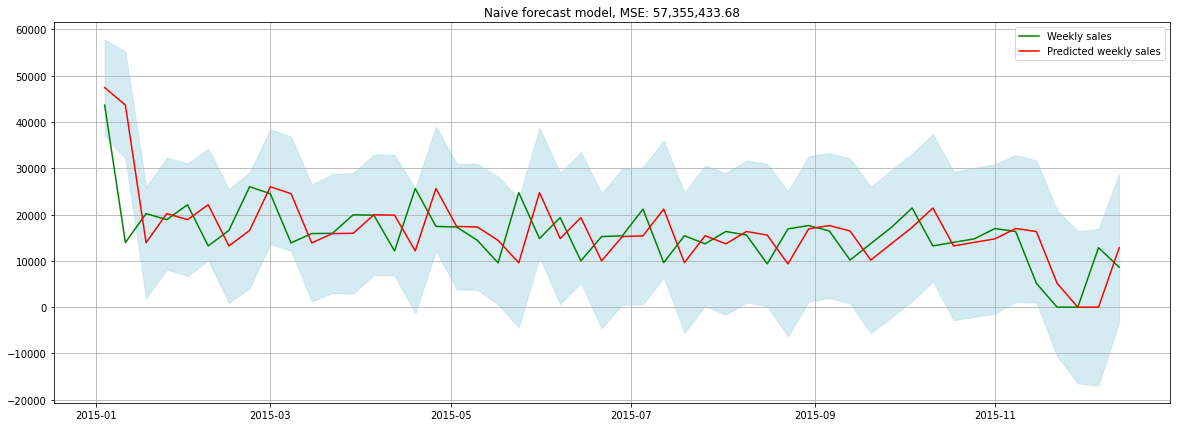

In [5]:
from sklearn.metrics import mean_squared_error
plt.rcParams["figure.figsize"] = (20,7)

df_pred = df_data.copy()
df_pred['weekly_sales_pred'] = df_pred['weekly_sales'].shift()

# calculate rolling standard deviation of using 50 values 
df_pred['std_50'] = df_pred['weekly_sales_pred'].rolling(50).std()

# get last 50 predictions
df_pred = df_pred[-50:]
# confidence interval
df_pred['ci_lower'] = df_pred['weekly_sales_pred']-2*df_pred['std_50']
df_pred['ci_upper'] = df_pred['weekly_sales_pred']+2*df_pred['std_50']

plt.plot(df_pred['weekly_sales'], color = 'green')
plt.plot(df_pred['weekly_sales_pred'], color = 'red')
plt.legend(['Weekly sales', 'Predicted weekly sales'])
plt.fill_between(df_pred.index,
                 df_pred['ci_lower'],
                 df_pred['ci_upper'], color='lightblue', alpha=0.5)
plt.title('Naive forecast model, MSE: {:,}'.format(round(
            mean_squared_error(df_pred['weekly_sales'], df_pred['weekly_sales_pred']),3)))
plt.grid()
plt.show()
del df_pred

<a id =topic2> </a> 
# Simple rolling mean (simple moving average)

<span style="font-family: Arial;font-size:1.1em">For a signal $y_{t}$, a simple rolling mean is just a mean over the last $k$ entries.

<span style="font-family: Arial;font-size:1.1em">$$y_{t} = \frac{y_{t-1} + y_{t-2} +...+y_{t-k}}{k}, t\geq k.$$

<span style="font-family: Arial;font-size:1.1em">Generally, the assumption of this method is stationarity of the signal but for the sake of example, this method will be applied both on the stationary and non-stationary signal. Also, with the short window (k), this method can work well even if the signal is non-stationary.

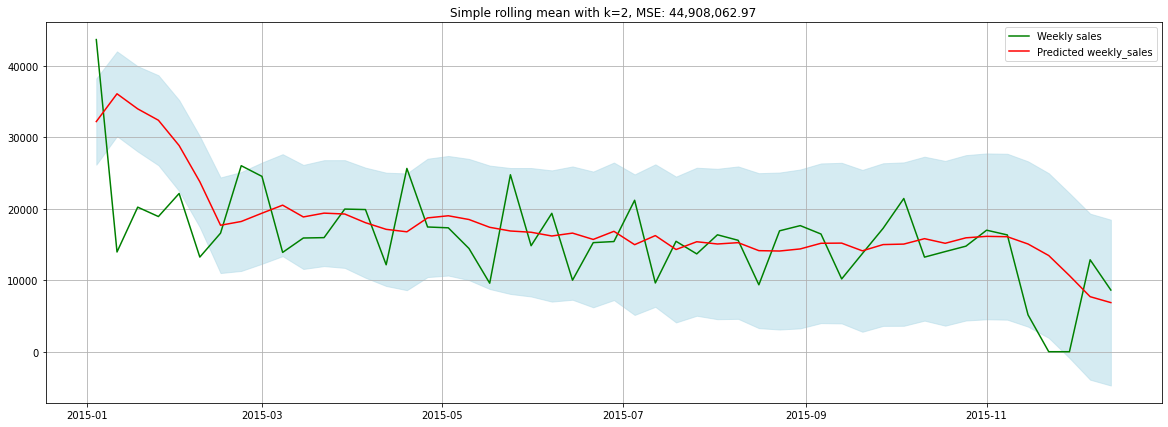

In [6]:
from sklearn.metrics import mean_squared_error

df_pred = df_data.copy()
df_pred['weekly_sales_t-1'] = df_pred['weekly_sales'].shift()

# mean of the last 5 values
df_pred['weekly_sales_pred'] = df_pred['weekly_sales_t-1'].rolling(5).mean()
df_pred['std_50'] = df_pred['weekly_sales_pred'].rolling(50).std()

# get last 50 weekly sales predictions
df_pred = df_pred[-50:]
# confidence interval
df_pred['ci_lower'] = df_pred['weekly_sales_pred']-2*df_pred['std_50']
df_pred['ci_upper'] = df_pred['weekly_sales_pred']+2*df_pred['std_50']

plt.plot(df_pred['weekly_sales'], color = 'green')
plt.plot(df_pred['weekly_sales_pred'], color = 'red')
plt.legend(['Weekly sales', 'Predicted weekly_sales'])
plt.fill_between(df_pred.index,
                 df_pred['ci_lower'],
                 df_pred['ci_upper'], color='lightblue', alpha=0.5)
plt.title('Simple rolling mean with k=2, MSE: {:,}'.format(round(mean_squared_error(
    df_pred['weekly_sales'], df_pred['weekly_sales_pred']), 2)))
plt.grid()
plt.show()
del df_pred

Rolling mean applied on the difference of weekly sales.

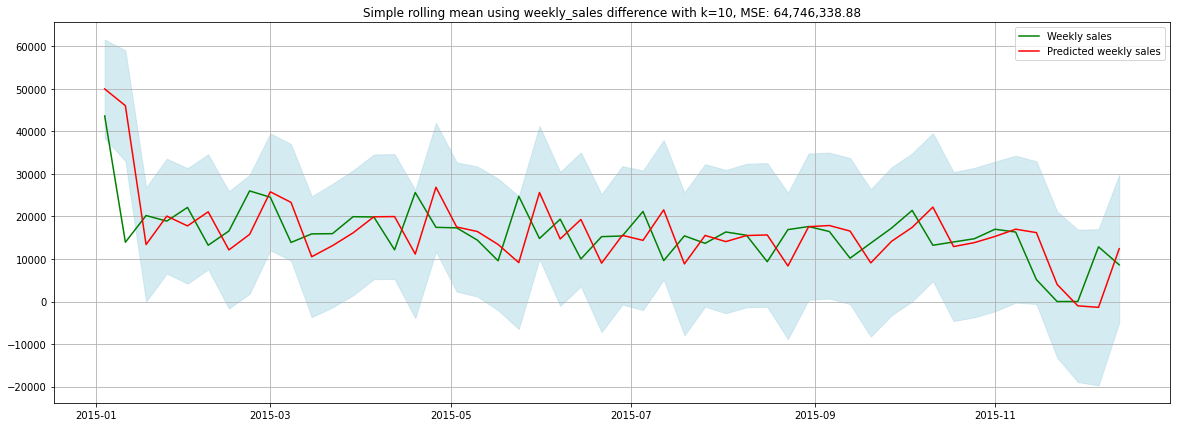

In [7]:
from sklearn.metrics import mean_squared_error


df_pred = df_data.copy()
df_pred['weekly_sales_diff'] = df_pred['weekly_sales'].diff()
df_pred = df_pred.dropna()

df_pred['weekly_sales_diff_t-1'] = df_pred['weekly_sales_diff'].shift()

# mean of the last 10 values
k = 10
df_pred['weekly_sales_diff_pred'] = df_pred['weekly_sales_diff_t-1'].rolling(k).mean()
df_pred['weekly_sales_pred'] = df_pred['weekly_sales_diff_pred'] + df_pred['weekly_sales'].shift()
df_pred['weekly_sales'] = df_pred['weekly_sales_diff'] + df_pred['weekly_sales'].shift()

df_pred['std_50'] = df_pred['weekly_sales_pred'].rolling(50).std()
 # get last 50 weekly sales predictions
df_pred = df_pred[-50:]
# confidence interval
df_pred['ci_lower'] = df_pred['weekly_sales_pred']-2*df_pred['std_50']
df_pred['ci_upper'] = df_pred['weekly_sales_pred']+2*df_pred['std_50']

plt.plot(df_pred['weekly_sales'], color = 'green')
plt.plot(df_pred['weekly_sales_pred'], color = 'red')
plt.legend(['Weekly sales', 'Predicted weekly sales'])
plt.fill_between(df_pred.index,
                 df_pred['ci_lower'],
                 df_pred['ci_upper'], color='lightblue', alpha=0.5)
plt.title('Simple rolling mean using weekly_sales difference with k={}, MSE: {:,}'.format(
    k,round(mean_squared_error(df_pred['weekly_sales'], df_pred['weekly_sales_pred']),2)))
plt.grid()
plt.show()
del df_pred

<a id =topic3> </a> 
# Weighted average

<div><span style="font-family: Arial;font-size:1.1em">This method is an improvement of the moving average with the addition of weights that multiply lagged values. 

$$y_{t} = w_{1}y_{t-1} + w_{2}y_{t-2} +...+w_{k}y_{t-k},\quad t\geq k,$$
$$w_{1} + w_{2} + ... + w_{k} = \sum_{i=1}^{k}w_{i} = 1,$$

where $y_{t}$ is a signal and $w_{i}$ are weights. Generally, the form of weighted average is

$$y_{t} = \frac{w_{1}y_{t-1} + w_{2}y_{t-2} +...+w_{k}y_{t-k}}{w_{1} + w_{2} + ... + w_{k}}, \quad t\geq k.$$

but with the simple transformation, it can be represented as at the top.<span></div>
<div><span style="font-family: Arial;font-size:0.8em">
$$y_{t} = \frac{\sum_{i=1}^{k}w_{i}(\frac{
w_{1}y_{t-1} + w_{2}y_{t-2} +...+w_{k}y_{t-k}}
{\sum_{j=1}^{k}w_{j}})
}{\sum_{i=1}^{k}w_{i}} = 
\frac{1(
    \frac{w_{1}y_{t-1}}{\sum_{j=1}^{k}w_{j}} + 
    \frac{w_{2}y_{t-2}}{\sum_{j=1}^{k}w_{j}} +...+
    \frac{w_{k}y_{t-k}}{\sum_{j=1}^{k}w_{j}}
    )
}{1} = w^{'}_{1}y_{t-1} + w^{'}_{2}y_{t-2} +...+w^{'}_{k}y_{t-k}, \quad t\geq k,$$<span></div>
<div><span style="font-family: Arial;font-size:1.1em">where
$$w^{'}_{i} = \frac{w_{i}}{\sum_{j=1}^{k}w_{j}}, \quad \overline{i=1, k}$$
and 
$$w^{'}_{1} + w^{'}_{2} + ... + w^{'}_{k} = 
\frac{w_{1}}{\sum_{j=1}^{k}w_{j}}+\frac{w_{2}}{\sum_{j=1}^{k}w_{j}}+...+\frac{w_{k}}{\sum_{j=1}^{k}w_{j}} =
\frac{\sum_{i=1}^{k}w_{i}}{\sum_{j=1}^{k}w_{j}} = 1.$$<span></div>

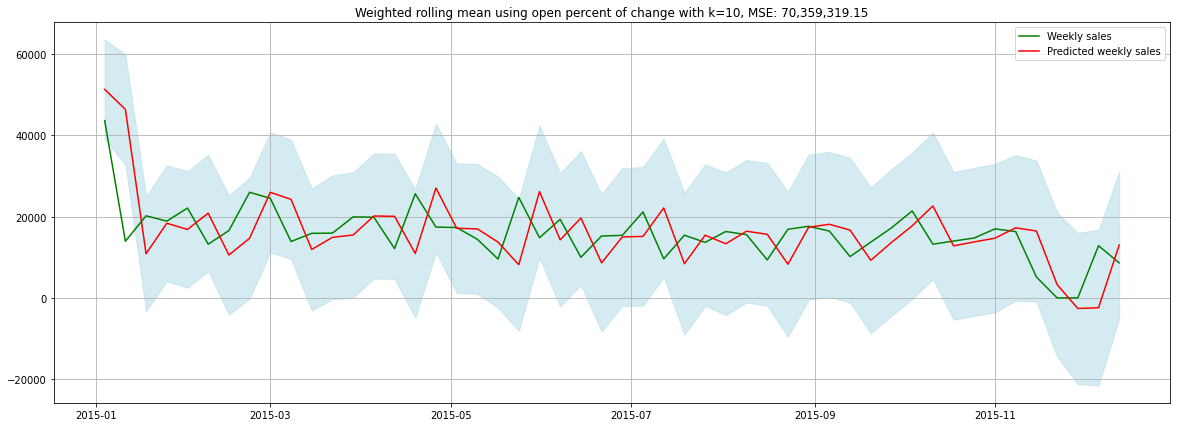

In [8]:
from sklearn.metrics import mean_squared_error


df_pred = df_data.copy()
df_pred['weekly_sales_diff'] = df_pred['weekly_sales'].diff()
df_pred = df_pred.dropna()

df_pred['weekly_sales_diff_t-1'] = df_pred['weekly_sales_diff'].shift()

k =10
#normalize linear weights
wts = np.arange(1,k+1)
wts = wts/np.sum(wts)

def wma(w):                        
    def g(x):
        return (w*x).sum()
    return g

df_pred['weekly_sales_diff_pred'] = df_pred['weekly_sales_diff_t-1'].rolling(k).apply(wma(wts))

df_pred['weekly_sales_pred'] = df_pred['weekly_sales_diff_pred'] + df_pred['weekly_sales'].shift()
df_pred['weekly_sales'] = df_pred['weekly_sales_diff'] + df_pred['weekly_sales'].shift()


df_pred['std_50'] = df_pred['weekly_sales_pred'].rolling(50).std()
 # get last 50 Open values predictions
df_pred = df_pred[-50:]
# confidence interval
df_pred['ci_lower'] = df_pred['weekly_sales_pred']-2*df_pred['std_50']
df_pred['ci_upper'] = df_pred['weekly_sales_pred']+2*df_pred['std_50']

plt.plot(df_pred['weekly_sales'], color = 'green')
plt.plot(df_pred['weekly_sales_pred'], color = 'red')
plt.legend(['Weekly sales', 'Predicted weekly sales'])
plt.fill_between(df_pred.index,
                 df_pred['ci_lower'],
                 df_pred['ci_upper'], color='lightblue', alpha=0.5)

plt.title('Weighted rolling mean using open percent of change with k={}, MSE: {:,}'.format(
    k,round(mean_squared_error(df_pred['weekly_sales'], df_pred['weekly_sales_pred']),2)))
plt.grid()
plt.show()
del df_pred

<a id =topic4> </a>
# Simple exponential smoothing (SES)

<div><span style="font-family: Arial;font-size:1.1em">This method forecasts a time series as a linear combination between the previous forecast and the previous error of that forecast. 

$$\hat{y}_{t} = \hat{y}_{t-1} + \alpha(\underbrace{y_{t-1} - \hat{y}_{t-1}}_\text{previous error}),$$
$$\hat{y}_{0} = y_{0},$$

where $\hat{y}_{t}$ is forecasted value at time $t$, $y_{t}$ real value at time $t$ and $\alpha \in [0,1]$ smoothing constant. For the easier calculation, this formula can be rewritten using the level updating equation as

$$\hat{y}_{t} = \alpha y_{t-1} + (1-\alpha)\hat{y}_{t-1}.$$

The term "exponential" stands for the coefficient $(1-\alpha)$ which becomes exponential through time if we unroll the formula above, ie.

\begin{equation}
\begin{split}
\hat{y}_{t} &= \alpha y_{t-1} + (1-\alpha)\hat{y}_{t-1}\\
            &= \alpha y_{t-1} + (1-\alpha)(\alpha y_{t-2} + (1-\alpha)\hat{y}_{t-2})\\
            &= \alpha y_{t-1} + \alpha (1-\alpha)y_{t-2} + (1-\alpha)^{2}\hat{y}_{t-2}\\
            &=\alpha(y_{t-1} + (1-\alpha)y_{t-2} + (1-\alpha)^{2}y_{t-3} + (1-\alpha)^{3}y_{t-4}+...+(1-\alpha)^{t-2}y_{1}) + (1-\alpha)^{t-1}y_{0}.
\end{split}
\end{equation}

Notice that from this form that SES forecasts future value using a weighted average of all previous values in the signal and weights decay exponentially into the past. 

This method is used for signals with no trend and no seasonality.</div>

  0%|          | 0/100 [00:00<?, ?it/s]

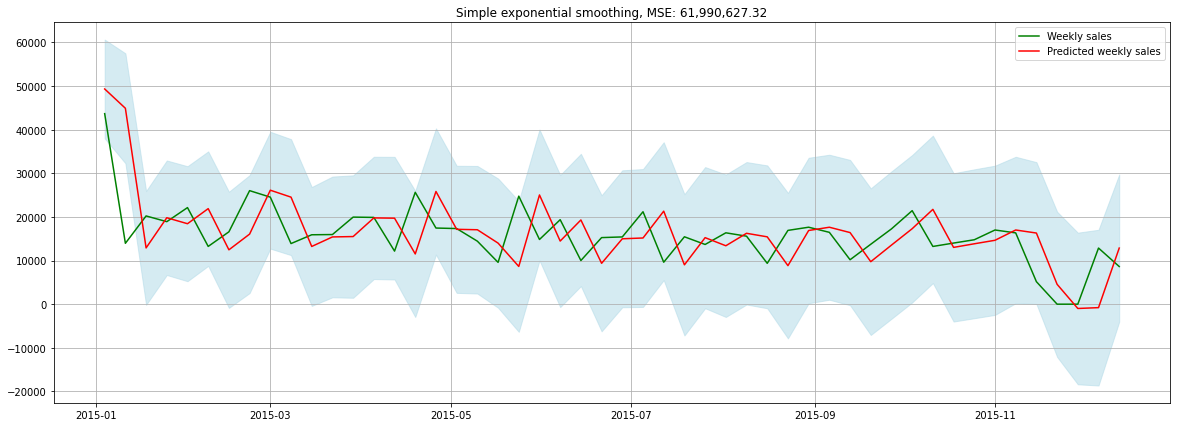

In [9]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

df_ses = df_data.copy()
df_ses['weekly_sales_diff'] = df_ses['weekly_sales'].diff()
df_ses = df_ses.dropna()

df_pred = pd.DataFrame()

# predict last 100 values
for i in tqdm(range(100)):
    
    training_data = df_ses['weekly_sales_diff'][:(-100+i)]
    
    model = SimpleExpSmoothing(training_data)
    # the alpha value can be set here using smoothing_level parameter
    # if it is not provided, the model will automatically optimize the value
    model_fit = model.fit()
    yhat = model_fit.predict().to_frame()
    df_pred = df_pred.append(yhat)

df_pred.columns = ['weekly_sales_diff_pred']
df_pred = pd.merge(df_pred, df_ses, how = 'left', left_index = True, right_index = True)
df_pred['weekly_sales_pred'] = df_pred['weekly_sales_diff_pred'] + df_ses['weekly_sales'].shift()
df_pred['weekly_sales'] = df_pred['weekly_sales_diff'] + df_ses['weekly_sales'].shift()

# create confidence interval
df_pred['std_50'] = df_pred['weekly_sales_pred'].rolling(50).std()
 # get last 50 Open values predictions
df_pred = df_pred[-50:]
# confidence interval
df_pred['ci_lower'] = df_pred['weekly_sales_pred']-2*df_pred['std_50']
df_pred['ci_upper'] = df_pred['weekly_sales_pred']+2*df_pred['std_50']

plt.plot(df_pred['weekly_sales'], color = 'green')
plt.plot(df_pred['weekly_sales_pred'], color = 'red')
plt.legend(['Weekly sales', 'Predicted weekly sales'])
plt.fill_between(df_pred.index,
                 df_pred['ci_lower'],
                 df_pred['ci_upper'], color='lightblue', alpha=0.5)

plt.title('Simple exponential smoothing, MSE: {:,}'.format(
    round(mean_squared_error(df_pred['weekly_sales'], df_pred['weekly_sales_pred']),2)))
plt.grid()
plt.show()

#del df_pred, df_ses

<a id =topic5> </a>
# Double exponential smoothing (Holt's exponential smoothing)

<div><span style="font-family: Arial;font-size:1.1em">Generally, we can think that time series is comprising of two parts:<br>
<ul>
<li><b>Systematic</b>- components that can be described and modeled.</li>
<li><b>Non-Systematic</b>- components that cannot be directly modeled (noise).</li>
</ul>    
Systematic part consist of three components:
<ul>
<li><b>Level</b>- the average value in the series.</li>
<li><b>Trend</b>- the increasing or decreasing value in the series.</li>
<li><b>Seasonality</b>- the repeating short-term cycle in the series.</li>
</ul>

Also, we can have an <b>additive model</b> where

$$y_{t} = \text{level} + \text{trend} + \text{seasonality} + \text{noise}$$

or <b>multiplicative model</b> where

$$y_{t} = \text{level} \cdot \text{trend} \cdot \text{seasonality} \cdot \text{noise}.$$

The distinction between signals which consisted of different components can be seen from the image below.</span></div>

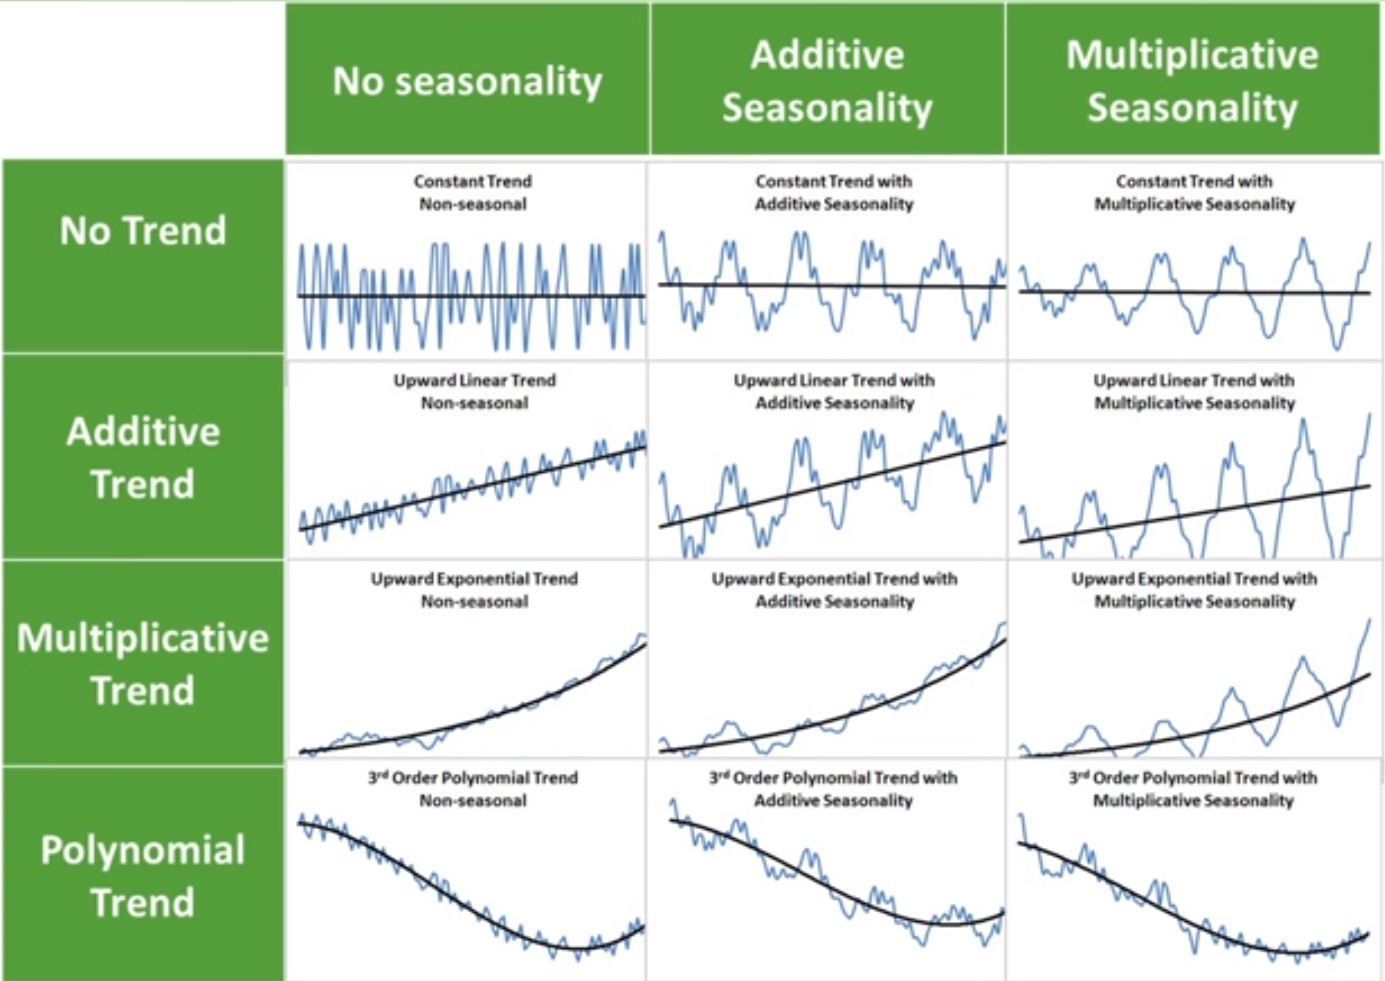
<div><span style="font-family: Arial;font-size:1.1em">$$\text{Source: Galit Shmueli, Smoothing 6: Winter's exponential smoothing, youtube.com}$$<br><br>

<b>Holt's exponential smoothing</b> is an extended version of simple exponential smoothing which allows the forecasting of data with a trend. This method, with <b>the additive trend</b>, estimates two smoothing equations (one for the level and one for the trend)

\begin{equation}
\begin{split}
\text{Forecast equation}& \quad \hat{y}_{t} &= l_{t-1} + b_{t-1}\\
\text{Level equation}& \quad l_{t-1} &= \alpha y_{t-1} + (1-\alpha)(l_{t-2} + b_{t-2})\\
\text{Trend equation}& \quad b_{t-1} &= \beta(l_{t-1} - l_{t-2}) + (1-\beta)b_{t-2},
\end{split}
\end{equation}

where $l_{t-1}$ denotes an estimate of the level of the series at time $t-1$, $b_{t-1}$ denotes an estimate of the trend of the series at time $t$, $\alpha \in [0, 1]$ is the smoothing parameter for the level and $\beta \in [0, 1]$ is the smoothing parameter for the trend.<br><br>

The level equation is similar to the SES equation with the difference in adjusting previous level $l_{t-2}$ by adding trend $b_{t-2}$. The trend equation updates previous trend $b_{t-2}$ using the difference between the most recent level values.<br><br>

In the case of <b>the multiplicative trend</b>, the only difference is in the forecasting equation where the multiplication sign stands instead of the plus sign.
$$\text{Forecast equation} \quad \hat{y}_{t} = l_{t-1} \cdot b_{t-1}$$

Note: Presented methods forecast only one step ahead. If we need to forecast more than one step, then the forecast equations have a slightly different form
\begin{equation}
\begin{split}
\text{Additive forecast equation}& \quad \hat{y}_{t+k} &= l_{t} + kb_{t}\\
\text{Multiplicative forecast equation}& \quad \hat{y}_{t+k} &= l_{t} \cdot (b_{t})^{k},
\end{split}
\end{equation}

where parameter $k$ denotes the number of forecasting steps.
<br><br>
This method is used for signals with trend and without seasonality. However, even if the signal contains seasonality, SEM can be applied after de-seasonalizing (for example, removing the seasonality by differencing with lag k).<span></div>

  0%|          | 0/100 [00:00<?, ?it/s]

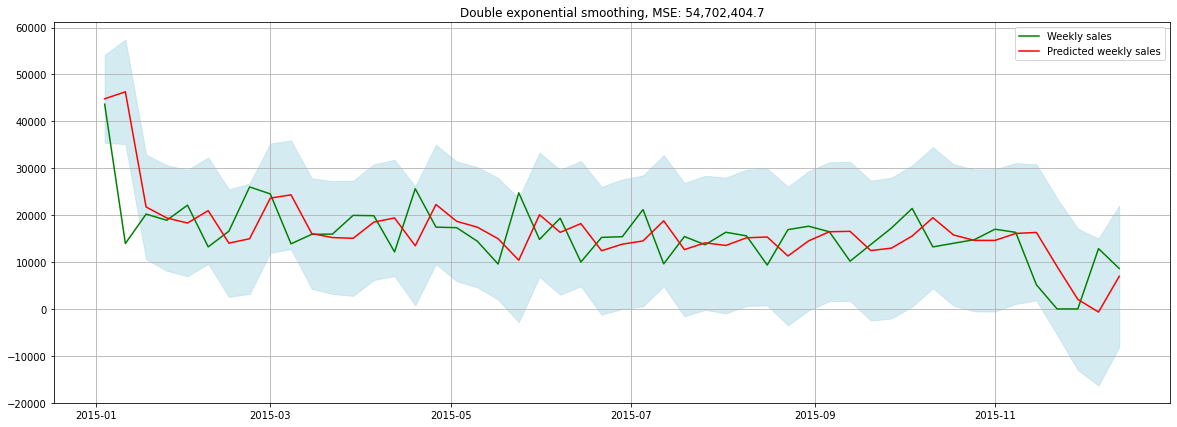

In [10]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

df_des = df_data.copy()

df_pred = pd.DataFrame()

# predict last 100 values
for i in tqdm(range(100)):
    
    training_data = df_des['weekly_sales'][:(-100+i)]
    
    model = ExponentialSmoothing(training_data, trend = 'add')
    
    model_fit = model.fit()
    yhat = model_fit.predict().to_frame()
    df_pred = df_pred.append(yhat)

df_pred.columns = ['weekly_sales_pred']
df_pred = pd.merge(df_pred, df_des, how = 'left', left_index = True, right_index = True)

# create confidence interval
df_pred['std_50'] = df_pred['weekly_sales_pred'].rolling(50).std()
df_pred['ci_lower'] = df_pred['weekly_sales_pred']-2*df_pred['std_50']
df_pred['ci_upper'] = df_pred['weekly_sales_pred']+2*df_pred['std_50']

df_pred = df_pred[-50:]

plt.plot(df_pred['weekly_sales'], color = 'green')
plt.plot(df_pred['weekly_sales_pred'], color = 'red')
plt.legend(['Weekly sales', 'Predicted weekly sales'])
plt.fill_between(df_pred.index,
                 df_pred['ci_lower'],
                 df_pred['ci_upper'], color='lightblue', alpha=0.5)
plt.title('Double exponential smoothing, MSE: {:,}'.format(round(
    mean_squared_error(df_pred['weekly_sales'], df_pred['weekly_sales_pred']),2)))
plt.grid()
plt.show()

<a id =topic6> </a>
# Triple exponential smoothing (Holt Winter’s Exponential Smoothing)

<div><span style="font-family: Arial;font-size:1.1em">HWES is extended version of double exponential smoothing method with addition of seasonal component (equation). It means that is applicable for signals <b>with trend and seasonality</b>.<br><br>

There are two types of seasonality in this method, additive and multiplicative. For instance, if every month of July the value of time series $y_{t}$ is higher than it is in June <b>by X</b>, then the seasonality is <b>additive</b> in nature. Otherwise, if the value in July is higher <b>by X%</b> then it means that the seasonality is <b>multiplicative</b>. The figure of signals with different type of seasonality is shown in the previous section.<br><br>

After all, <b>Holt Winter's</b> method with <b>additive trend</b> and <b>additive seasonality</b> that forecasts <b>one step</b> ahead is given by

\begin{equation}
\begin{split}
\text{Forecast equation}& \quad \hat{y}_{t+1} &= l_{t} + b_{t} + s_{t-m}\\
\text{Level equation}& \quad l_{t} &= \alpha (y_{t}-s_{t-m}) + (1-\alpha)(l_{t-1} + b_{t-1})\\
\text{Trend equation}& \quad b_{t} &= \beta(l_{t} - l_{t-1}) + (1-\beta)b_{t-1}\\
\text{Seasonal equation}& \quad s_{t} &= \gamma(y_{t} - l_{t-1} - b_{t-1}) + (1-\gamma)s_{t-m},
\end{split}
\end{equation}

where $l_{t}$ denotes an estimate of the signal level at time $t$, $b_{t}$ denotes an estimate of the signal trend at time $t$, $s_{t}$ denotes an estimate of the signal seasonality at time $t$, $\alpha \in [0, 1]$ is the smoothing parameter for the level, $\beta \in [0, 1]$ is the smoothing parameter for the trend and $\gamma \in [0, 1]$ is the smoothing parameter for the seasonality. Parameter $m$ denotes the frequency of the seasonality. For example, for quarterly data $m=4$, and for monthly data $m=12.$<br><br>

Notice the differences between double and triple exponential smoothing. The seasonal equation is new and the seasonal estimate $s_{t-m}$ is added in the forecast equation. Also, in the level equation, the only difference is $(y_{t}-s_{t-m})$ which means de-seasonalizing of the value $y_{t}$. Everything else in the formula is the same. The formula which has multiplicative trend or multiplicative seasonality or longer forecasting period is slightly different and will not be mentioned here.<br><br>

This method is applicable for signals with trend and seasonality.<span></div>

  0%|          | 0/100 [00:00<?, ?it/s]

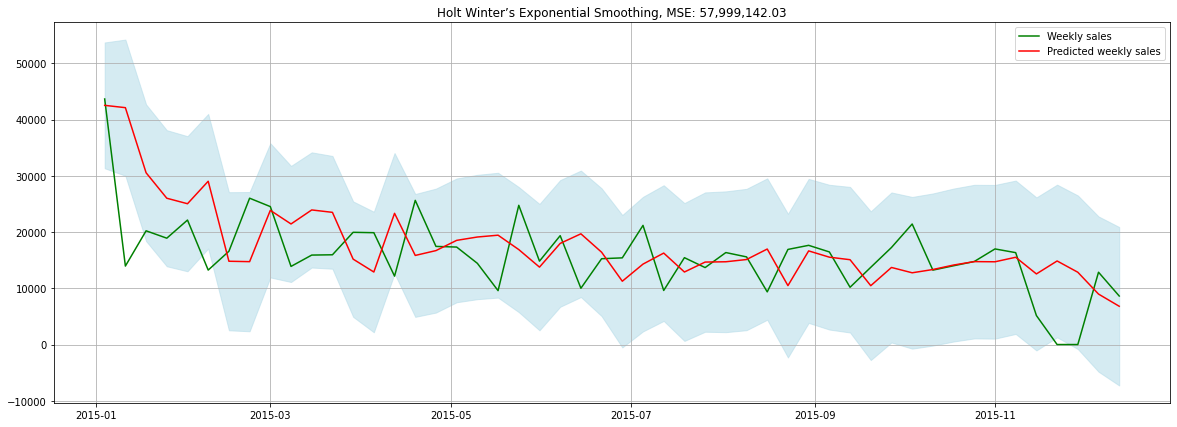

In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

df_tes = df_data.copy()

df_pred = pd.DataFrame()

# predict last 100 values
for i in tqdm(range(100)):
    
    training_data = df_tes['weekly_sales'][:(-100+i)]
    
    model = ExponentialSmoothing(training_data, trend='add',
                                 seasonal='add',seasonal_periods=12)
    
    model_fit = model.fit()
    yhat = model_fit.predict().to_frame()
    df_pred = df_pred.append(yhat)

df_pred.columns = ['weekly_sales_pred']
df_pred = pd.merge(df_pred, df_tes, how = 'left', left_index = True, right_index = True)

# create confidence interval
df_pred['std_50'] = df_pred['weekly_sales_pred'].rolling(50).std()
df_pred['ci_lower'] = df_pred['weekly_sales_pred']-2*df_pred['std_50']
df_pred['ci_upper'] = df_pred['weekly_sales_pred']+2*df_pred['std_50']

df_pred = df_pred[-50:]

plt.plot(df_pred['weekly_sales'], color = 'green')
plt.plot(df_pred['weekly_sales_pred'], color = 'red')
plt.legend(['Weekly sales', 'Predicted weekly sales'])
plt.fill_between(df_pred.index,
                 df_pred['ci_lower'],
                 df_pred['ci_upper'], color='lightblue', alpha=0.5)
plt.title('Holt Winter’s Exponential Smoothing, MSE: {:,}'.format(round(
    mean_squared_error(df_pred['weekly_sales'], df_pred['weekly_sales_pred']),2)))
plt.grid()
plt.show()
del df_tes

<a id =topic10> </a> 
# Autoregressive Model (AR)

<div><span style="font-family: Arial;font-size:1.1em">A model where signal $S_{t}$ depends only on its own past values. For example, AR(3) is a model that depends on 3 of its past values and can be written as $$ S_{t} =\beta_{0} + \beta_{1}S_{t-1} + \beta_{2}S_{t-2} + \beta_{3}S_{t-3} + \epsilon_{t},  $$
where $\beta_{0}, \beta_{1}, \beta_{2}, \beta_{3}$ are coefficients and $\epsilon_{t}$ is error. 

The order p for AR(p) model can be selected based on significant spikes from the PACF plot. One more indication of AR process is that ACF plot decays more slowly.

AR model requires stationarity.<span></div>

In [12]:
from statsmodels.tsa.arima.model import ARIMA

df_ar = df_data.copy()
df_ar['weekly_sales_diff'] = df_ar['weekly_sales'].diff()
df_ar = df_ar.dropna()

training_data = df_ar['weekly_sales_diff'][:-50]

# order = (p, d, q) where AR(p)
model = ARIMA(training_data, order = (3, 0, 0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      weekly_sales_diff   No. Observations:                  103
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -1028.759
Date:                Sat, 17 Apr 2021   AIC                           2067.517
Time:                        21:20:19   BIC                           2080.691
Sample:                    01-13-2013   HQIC                          2072.853
                         - 12-28-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        239.4077    298.247      0.803      0.422    -345.146     823.962
ar.L1         -0.2795      0.076     -3.701      0.000      -0.428      -0.131
ar.L2         -0.3586      0.064     -5.625      0.000      -0.484      -0.234
ar.L3         -0.1863      0.103     -1.816      0.069      -0.387       0.015
sigma2      2.813e+07      0.009   3.27e+09      0.000    2.81e+07    2.81e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                41.37
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                             0.72
Prob(H) (two-sided):                  0.22   Kurtosis:                         5.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.53e+25. Standard errors may be unstable.
"""

<a id =topic10.1> </a> 
<div><span style="font-family: Arial;font-size:1.1em"> From the summary above in a top section can be seen some information about model and training data, as well as measures of a model such as Akaike Information Criteria (AIC) and Bayesian Information Criteria (BIC). The lower the value of these criteria, the better the model.<br><br>
$$AIC = 2k - 2l$$ and
$$BIC = k\log(n) - 2l,$$ where $l$ is a log-likelihood (how strong the model is in fitting the data), $k$ is a number of parameters (more parameters - more complicated model and AR(p) has p+1 parameters) and $n$ is a number of samples used for fitting (size of the training set).<br><br>

In the middle section, we can see a table with information about coefficients of the AR(3) model. The most important column is a <b>p-value P>|Z|</b>. This column shows the importance of each lag or each coefficient in the model and the lower the <b>p-value</b>, the more significant is coefficient in our prediction. Ideally, we want that <b>p-value</b> is less than 0.05.<span></div>

  0%|          | 0/50 [00:00<?, ?it/s]

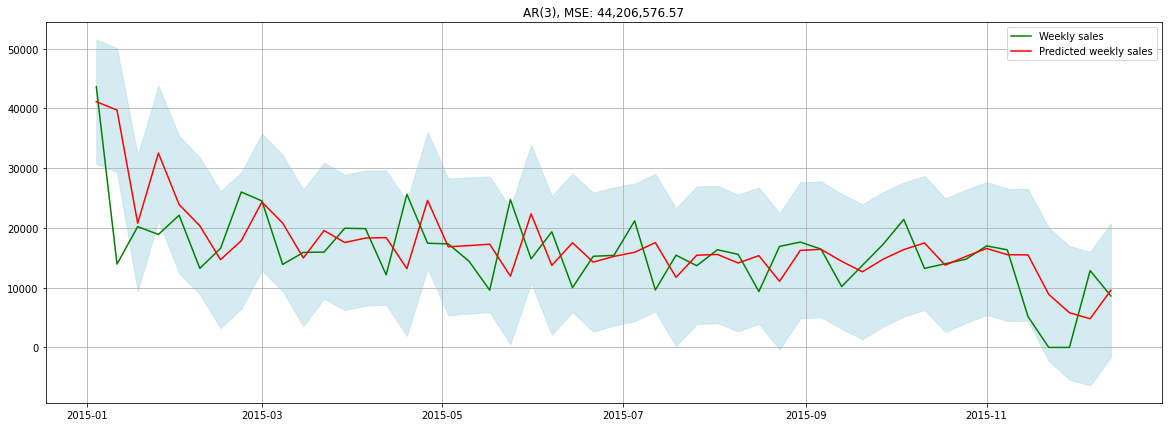

In [13]:
from tqdm.notebook import tqdm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# predict last 50 Return values one by one
# also called rolling forecasting origin

df_ar = df_data.copy()
df_ar['weekly_sales_diff'] = df_ar['weekly_sales'].diff()
df_ar = df_ar.dropna()

df_pred = pd.DataFrame()

for i in tqdm(range(50)):
    
    training_data = df_ar['weekly_sales_diff'][:(-50+i)]
    
    #order = (p, d, q) where AR(p)
    model = ARIMA(training_data, order = (3, 0, 0))
    model_fit = model.fit()
    pred_temp = model_fit.get_forecast(1).summary_frame()
    df_pred = df_pred.append(pred_temp)

df_pred = pd.merge(df_pred, df_ar, how = 'left', left_index = True, right_index = True)
df_pred['weekly_sales_pred'] = df_pred['mean'] + df_ar['weekly_sales'].shift()
df_pred['weekly_sales'] = df_pred['weekly_sales_diff'] + df_ar['weekly_sales'].shift()
df_pred['ci_lower'] = df_pred['mean_ci_lower'] + df_ar['weekly_sales'].shift()
df_pred['ci_upper'] = df_pred['mean_ci_upper'] + df_ar['weekly_sales'].shift()

plt.rcParams["figure.figsize"] = (20,7)
plt.plot(df_pred['weekly_sales'], color = 'green')
plt.plot(df_pred['weekly_sales_pred'], color = 'red')
plt.legend(['Weekly sales', 'Predicted weekly sales'])
plt.fill_between(df_pred.index,
                 df_pred['ci_lower'],
                 df_pred['ci_upper'], color='lightblue', alpha=0.5)
plt.title('AR(3), MSE: {:,}'.format(round(
                mean_squared_error(df_pred['weekly_sales'], df_pred['weekly_sales_pred']),2)))
plt.grid()
plt.show()
del df_ar, df_pred

<a id =topic11> </a>
# Moving Average Model (MA)

<div><span style="font-family: Arial;font-size:1.1em"> MA is the model which depends on the past error terms. For example, MA(3) for a signal $S_{t}$ can be formulated as <br><br>
$$S_{t} = \mu + \epsilon_{t} + \gamma_{1}\epsilon_{t-1}+\gamma_{2}\epsilon_{t-2}+\gamma_{3}\epsilon_{t-3}, $$
<br>
where $\mu$ is the mean of a series, $\gamma_{1}, \gamma_{2}, \gamma_{3}$ are coefficients and $\epsilon_{t}, \epsilon_{t-1}, \epsilon_{t-2}, \epsilon_{t-3}$ are errors which have a normal distribution with mean 0 and std 1 (sometimes called white noise).

The order q for model MA(q) can be selected from ACF if this plot has a sharp cut-off after lag q. One more indication of MA process is that PACF plot decays more slowly.<br><br>  

MA model requires stationarity.<span></div>

  0%|          | 0/50 [00:00<?, ?it/s]

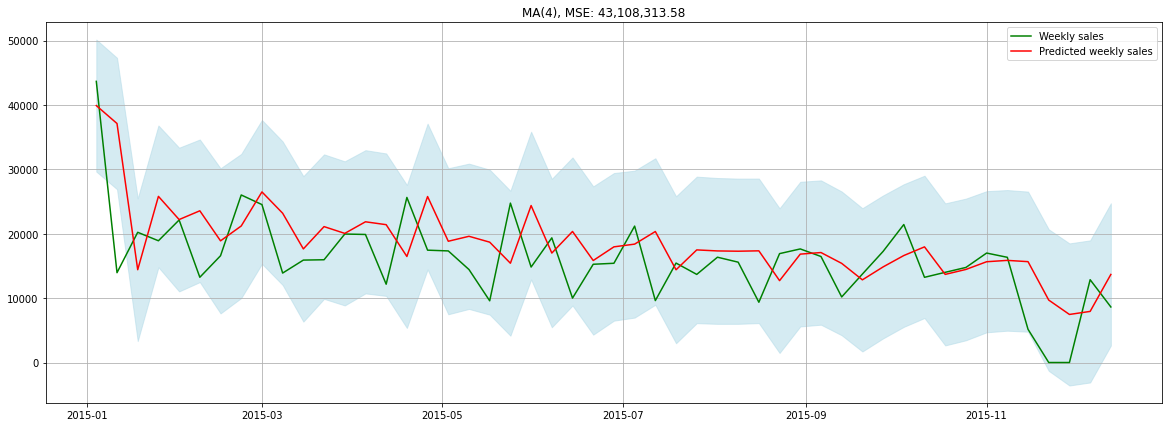

In [14]:
from tqdm.notebook import tqdm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# predict last 50 Return values one by one
# also called rolling forecasting origin

df_ma = df_data.copy()
df_ma['weekly_sales_diff'] = df_ma['weekly_sales'].diff()
df_ma = df_ma.dropna()

df_pred = pd.DataFrame()

for i in tqdm(range(50)):
    
    training_data = df_ma['weekly_sales_diff'][:(-50+i)]
    
    #order = (p, d, q) where MA(q)
    model = ARIMA(training_data, order = (0, 0, 4))
    model_fit = model.fit()
    pred_temp = model_fit.get_forecast(1).summary_frame()
    df_pred = df_pred.append(pred_temp)

df_pred = pd.merge(df_pred, df_ma, how = 'left', left_index = True, right_index = True)
df_pred['weekly_sales_pred'] = df_pred['mean'] + df_ma['weekly_sales'].shift()
df_pred['weekly_sales'] = df_pred['weekly_sales_diff'] + df_ma['weekly_sales'].shift()
df_pred['ci_lower'] = df_pred['mean_ci_lower'] + df_ma['weekly_sales'].shift()
df_pred['ci_upper'] = df_pred['mean_ci_upper'] + df_ma['weekly_sales'].shift()

plt.rcParams["figure.figsize"] = (20,7)
plt.plot(df_pred['weekly_sales'], color = 'green')
plt.plot(df_pred['weekly_sales_pred'], color = 'red')
plt.legend(['Weekly sales', 'Predicted weekly sales'])
plt.fill_between(df_pred.index,
                 df_pred['ci_lower'],
                 df_pred['ci_upper'], color='lightblue', alpha=0.5)
plt.title('MA(4), MSE: {:,}'.format(round(
                mean_squared_error(df_pred['weekly_sales'], df_pred['weekly_sales_pred']),2)))
plt.grid()
plt.show()
del df_ma, df_pred

<a id =topic12> </a>
# Autoregressive Moving Average Model (ARMA)

<div><span style="font-family: Arial;font-size:1.1em">ARMA(p,q) is a combination of AR(p) and MA(q) models. For example, ARMA(3,3) of signal $S_{t}$ can be formulated as<br><br>
$$S_{t} =\beta_{0} + \beta_{1}S_{t-1} + \beta_{2}S_{t-2} + \beta_{3}S_{t-3} + \epsilon_{t} + \gamma_{1}\epsilon_{t-1}+\gamma_{2}\epsilon_{t-2}+\gamma_{3}\epsilon_{t-3},$$<br>
where $\beta, \gamma$ are coefficients and $\epsilon$ error.<br><br>
ARMA model requires stationarity.<span></div>

  0%|          | 0/50 [00:00<?, ?it/s]

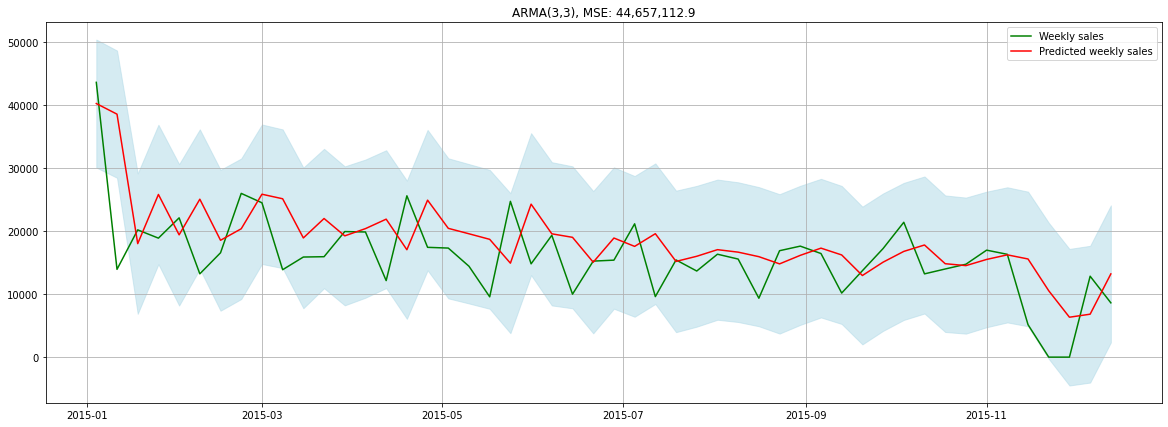

In [15]:
from tqdm.notebook import tqdm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# predict last 50 Return values one by one
# also called rolling forecasting origin

df_arma = df_data.copy()
df_arma['weekly_sales_diff'] = df_arma['weekly_sales'].diff()
df_arma = df_arma.dropna()

df_pred = pd.DataFrame()

for i in tqdm(range(50)):
    
    training_data = df_arma['weekly_sales_diff'][:(-50+i)]
    
    #order = (p, d, q) where MA(q)
    model = ARIMA(training_data, order = (3, 0, 3))
    model_fit = model.fit()
    pred_temp = model_fit.get_forecast(1).summary_frame()
    df_pred = df_pred.append(pred_temp)

df_pred = pd.merge(df_pred, df_arma, how = 'left', left_index = True, right_index = True)
df_pred['weekly_sales_pred'] = df_pred['mean'] + df_arma['weekly_sales'].shift()
df_pred['weekly_sales'] = df_pred['weekly_sales_diff'] + df_arma['weekly_sales'].shift()
df_pred['ci_lower'] = df_pred['mean_ci_lower'] + df_arma['weekly_sales'].shift()
df_pred['ci_upper'] = df_pred['mean_ci_upper'] + df_arma['weekly_sales'].shift()

plt.rcParams["figure.figsize"] = (20,7)
plt.plot(df_pred['weekly_sales'], color = 'green')
plt.plot(df_pred['weekly_sales_pred'], color = 'red')
plt.legend(['Weekly sales', 'Predicted weekly sales'])
plt.fill_between(df_pred.index,
                 df_pred['ci_lower'],
                 df_pred['ci_upper'], color='lightblue', alpha=0.5)
plt.title('ARMA(3,3), MSE: {:,}'.format(round(
                mean_squared_error(df_pred['weekly_sales'], df_pred['weekly_sales_pred']),2)))
plt.grid()
plt.show()
del df_arma, df_pred

<a id =topic13> </a>
# Autoregressive Integrated Moving Average Model (ARIMA)

<div><span style="font-family: Arial;font-size:1.1em">ARIMA(p,d,q) model is the ARMA(p,q) model with additional functionality I(d) that makes time series stationary. I(d) defines an order of integration. 
For example, ARIMA(3,1,3) of signal $S_{t}$ can be formulated as<br><br> 
$$S^{'}_{t} =\beta_{0} + \beta_{1}S^{'}_{t-1} + \beta_{2}S^{'}_{t-2} + \beta_{3}S^{'}_{t-3} + \epsilon_{t} + \gamma_{1}\epsilon_{t-1}+\gamma_{2}\epsilon_{t-2}+\gamma_{3}\epsilon_{t-3}, $$ where $$S^{'}_{t} = S_{t} - S_{t-1}$$
and $\beta, \gamma$ are coefficients and $\epsilon$ error.<br>
From the last equation, $$S_{t} = S^{'}_{t} + S_{t-1} = S^{'}_{t}+S^{'}_{t-1} + S_{t-2}=...=\sum^{t-1}_{i=1}S^{'}_{t-i}+S_{0}.$$

<b><u>ARIMA can handle 2 types of non-stationarity</u></b>: hidden trend, such as linear and polynomial, and unit roots. Differencing removes any type of polynomial trend. The higher-degree polynomial is, the more differencing needed.<br><br>

If the coefficient which multiplies lagged value in AR process is equal to 1, then the time series has <b>a unit root</b>. For example, for a given AR(1) signal $$S_{t} =\beta_{0} + \beta_{1}S_{t-1}+\epsilon_{t},$$ if $\beta_{1}=1$ then the signal has a unit root. This signal is a typical case of <b>random walk</b>. In addition, if coefficient $\beta_{0}$ is different than zero, signal $S_{t}$ is called <b>random walk with drift</b>. To find whether time series has a unit root or not, we can use Dickey–Fuller test (not ADF).<br><br> 

Also, differencing removes 1 unit root per application. If there are 2 unit roots, we will need differencing twice. 3 unit roots - three times, etc. <span></div>

  0%|          | 0/50 [00:00<?, ?it/s]

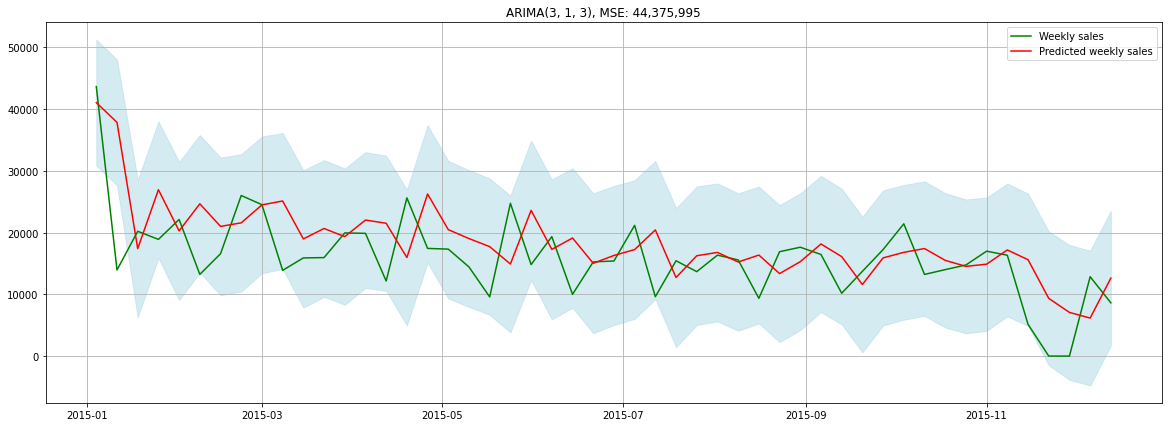

In [16]:
from tqdm.notebook import tqdm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
plt.rcParams["figure.figsize"] = (20,7)

# predict last 50 Open values one by one

df_pred = pd.DataFrame()

for i in tqdm(range(50)):
    
    # we will use directly open price without transforming
    training_data = df_data['weekly_sales'][:(-50+i)]
    
    #order = (p, d, q)
    model = ARIMA(training_data, order = (3, 1, 3))
    model_fit = model.fit()
    pred_temp = model_fit.get_forecast(1).summary_frame()
    df_pred = df_pred.append(pred_temp)

df_pred['weekly_sales'] = df_data['weekly_sales'][-50:]

plt.plot(df_pred['weekly_sales'], color = 'green')
plt.plot(df_pred['mean'], color = 'red')
plt.legend(['Weekly sales', 'Predicted weekly sales'])
plt.fill_between(df_pred.index,
                 df_pred['mean_ci_lower'],
                 df_pred['mean_ci_upper'], color='lightblue', alpha=0.5)
plt.title('ARIMA(3, 1, 3), MSE: {:,}'.format(round(mean_squared_error(
    df_pred['weekly_sales'], df_pred['mean'])), 2))
plt.grid()
plt.show()

<a id =topic14> </a>
# Seasonal Autoregressive Integrated Moving Average Model (SARIMA)


<div><span style="font-family: Arial;font-size:1.1em">SARIMA(p, d, q)(P, D, Q)m is an extenson of ARIMA(p, d, q). New parameters P, D and Q stands for seasonal autoregressive, integrated and moving average order respectively. Parameter $m$ means how many time steps are there in a single seasonal period.<br><br>

To understand the formula behind ARIMA model, we need first to understand the backward shift operator $B$ defined as $$By_{t} = y_{t-1}.$$ Analogously, $$B(By_{t}) = B^{2}y_{t} = y_{t-2}$$
This operator is just convenient way of describing the process of differencing because the first difference can be written as $$y^{'}_{t} = y_{t} - y_{t-1} = y_{t} - By_{t} = (1-B)y_{t}$$ and second difference as $$y^{"}_{t}= ( y_{t} - y_{t-1})^{'} = y^{'}_{t} - y^{'}_{t-1} = y_{t} - y_{t-1} - (y_{t-1} - y_{t-2}) = y_{t} - 2y_{t-1} + y_{t-2} = (1-2B+B^{2})y_{2} = (1-B)^{2}y_{t}.$$
In general, d-order difference can be formulated as $$y^{(d)}_{t} = (1-B)^{(d)}y_{t}.$$
Finally, SARIMA(1,1,1)(1,1,1)4 can be formulated as
$$\underbrace{(1-\phi_{1}B)}_\text{p}\underbrace{(1-\Phi_{1}B^{4})}_\text{P}\underbrace{(1-B)}_\text{d}\underbrace{(1-B^{4})}_\text{D}y_{t}=c + \underbrace{(1+\theta_{1}B)}_\text{q}\underbrace{(1+\Theta_{1}B^{4})}_\text{Q}\epsilon_{t}$$ where $\phi, \Phi, \theta, \Theta, c$ are coefficients and $B$ is backward shift operator. Notice that all brackets represent a version of operator's B polynomial of first difference $(1-B)$ because $p=d=q=P=D=Q=1$ and $B^{4}$ in some of them is due to $m=4.$ From that, if the one the parameters $p, d, q, P, D, Q$ is different than 1, then we need to use a corresponding polynomial. For example if $p=2$, then from  $(1-B)^{2} = (1-2B+B^{2})$ matching polynomial is $(1-\phi_{1}B + \phi_{2}B^{2}$). Similar, for $P=2$, matching polynomial is $(1-\Phi_{1}B^{4} + \Phi_{2}B^{8}$) (if $m=4$).<br><br>

As for AR and MA, seasonal part of SARIMA model can be seen from PACF and ACF plot.
For example, SARIMA(0, 0, 0)(0, 0, 1)4 model will show:
<ul>
<li>a spike at lag 4 in the ACF but no other significant spikes,</li>
<li>exponential decay in the seasonal lags of the PACF (at lags 4, 8, 12, ...).</li>    
</ul>

For SARIMA(0, 0, 0)(1, 0, 0)4 it will be opposite:
<ul>
<li>exponential decay in the seasonal lags of the ACF,</li>
<li>a single significant spike at lag 4 in the PACF.</li>
</ul>

However, maybe the best option is to apply grid search using predefined set of SARIMA hyperparameters or using <i>auto_arima</i> which will select the best model based on AIC.<span></div> 

In [17]:
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 1.3 MB/s 
     |████████████████████████████████| 2.1 MB 7.2 MB/s 
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22


In [18]:
#!pip install pmdarima

from pmdarima import auto_arima
training_data = df_data['weekly_sales'][:-50]

# Note, by default m=1 which means that data is non-seasonal.
# This parameter must be known apriori.
# For the sake of example m>1 will be used.
smodel = auto_arima(training_data, start_p=0, start_q=0,
                       max_p=3, max_q=3, max_d = 2,
                       seasonal=True,m=4,
                       start_P=0, start_Q = 0, max_P = 3, max_Q = 3,
                       max_D = 2,information_criterion='aic',test='adf',
                       trace=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=2077.261, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=2078.911, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=2077.667, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=2075.449, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=2077.954, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=2077.906, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=2079.906, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=2078.038, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=2076.361, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=2072.316, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[4] intercept   : AIC=2073.466, Time=0.09 sec
 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=2072.970, Time=0.12 sec
 ARIMA(1,1,1)(1,0,1)[4] intercept   : AIC=2074.216, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[4] intercept   : AIC=2069.893, Time=0.09 sec
 ARIMA(2,1,1)(1,0,0)[4] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  104
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1030.454
Date:                Sat, 17 Apr 2021   AIC                           2066.908
Time:                        21:22:19   BIC                           2074.812
Sample:                             0   HQIC                          2070.109
                                - 104                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2862      0.073     -3.907      0.000      -0.430      -0.143
ma.L2         -0.3251      0.062     -5.231      0.000      -0.447      -0.203
sigma2      2.712e+07    1.2e-09   2.26e+16      0.000    2.71e+07    2.71e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                36.34
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             0.83
Prob(H) (two-sided):                  0.49   Kurtosis:                         5.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.04e+31. Standard errors may be unstable.
"""

  0%|          | 0/50 [00:00<?, ?it/s]

best model (0, 1, 2) best model (1, 0, 0) best model (0, 0, 1) best model (0, 1, 0) best model (0, 1, 0) best model (0, 1, 0) best model (0, 1, 3) best model (0, 1, 0) best model (0, 1, 0) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 2) best model (0, 1, 2) best model (1, 1, 1) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (1, 1, 1) best model (0, 1, 3) best model (1, 1, 1) best model (1, 1, 1) best model (1, 1, 1) best model (1, 1, 1) best model (1, 1, 1) best model (1, 1, 1) best model (1, 1, 1) best model (1, 1, 1) best model (1, 1, 1) best model (1, 1, 1) best model (1, 1, 1) best model (1, 1, 1) best model (1, 1, 1) best model (1, 1, 1) best model (1, 1, 1) best model (1, 1, 1) best model (1, 1, 1) best model (1

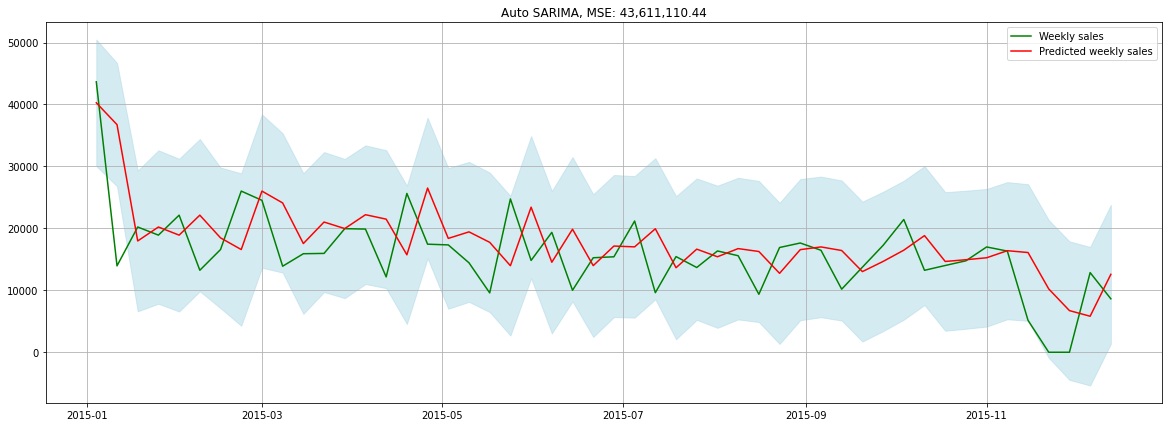

In [19]:
from tqdm.notebook import tqdm
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from dateutil.relativedelta import relativedelta
plt.rcParams["figure.figsize"] = (20,7)

# predict last 50 weekly sales values one by one

pred_dict = {'date':[], 'pred_weekly_sales':[], 'ci_lower':[],'ci_upper':[] }

for i in tqdm(range(50)):
    
    # we will use directly weekly sales without transforming
    training_data = df_data['weekly_sales'][:(-50+i)]
    
    model = auto_arima(training_data)
    print('best model {}'.format(model.get_params()['order']), end = ' ')
    pred, confint = model.predict(n_periods=1, return_conf_int=True)
    pred_date = training_data.index[-1] + relativedelta(weeks = 1)
    
    pred_dict['date'].append(pred_date)
    pred_dict['pred_weekly_sales'].append(pred[0])
    pred_dict['ci_lower'].append(confint[0][0])
    pred_dict['ci_upper'].append(confint[0][1])
    

df_pred = pd.DataFrame(pred_dict)
df_pred = df_pred.set_index('date')
df_pred['weekly_sales'] = df_data['weekly_sales'][-50:]

plt.plot(df_pred['weekly_sales'], color = 'green')
plt.plot(df_pred['pred_weekly_sales'], color = 'red')
plt.legend(['Weekly sales', 'Predicted weekly sales'])
plt.fill_between(df_pred.index,
                 df_pred['ci_lower'],
                 df_pred['ci_upper'], color='lightblue', alpha=0.5)
plt.title('Auto SARIMA, MSE: {:,}'.format(round(mean_squared_error(
    df_pred['weekly_sales'], df_pred['pred_weekly_sales']),2)))
plt.grid()
plt.show()

<a id =topic15> </a> 
# Seasonal Autoregressive Integrated Moving Average Model with Exogenous Regressors(SARIMAX)

<div><span style="font-family: Arial;font-size:1.1em">SARIMAX model is an extension of SARIMA model which simply adds exogenous variables, also called covariates. Exogenous variables represent additional factors or input features for the model, which have observations at the same time steps as the forecasted series. It means that for forecasting $y_{t+1}$, the exogenous input should have the same time-step, i.e. $x_{t+1}$. Formally, SARIMAX(1,1,1)(1,1,1)4 with one exogenous time series $x_{t}$ can be written as

$$y_{t} = \beta_{0} + \beta_{1}x_{t} + u_{t}$$
$$\underbrace{(1-\phi_{1}B)}_\text{p}\underbrace{(1-\Phi_{1}B^{4})}_\text{P}\underbrace{(1-B)}_\text{d}\underbrace{(1-B^{4})}_\text{D}u_{t}=\underbrace{(1+\theta_{1}B)}_\text{q}\underbrace{(1+\Theta_{1}B^{4})}_\text{Q}\epsilon_{t}.$$

Notice that the first equation is just a linear regression and the second equation describes SARIMA process. 

In this example, as the exogenous variable will be used standard deviation of the last 3 weekly sales.<span></div>

  0%|          | 0/50 [00:00<?, ?it/s]

best model (0, 1, 2) best model (2, 0, 1) best model (0, 1, 0) best model (0, 1, 0) best model (0, 1, 0) best model (0, 1, 0) best model (0, 1, 0) best model (0, 1, 0) best model (0, 1, 0) best model (0, 1, 0) best model (0, 1, 0) best model (0, 1, 0) best model (0, 1, 0) best model (0, 1, 0) best model (0, 1, 0) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 2) best model (0, 1, 2) best model (0, 1, 2) best model (0, 1, 2) best model (0, 1, 2) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (1, 1, 1) best model (1, 1, 1) best model (0, 1, 3) best model (1, 1, 1) best model (1, 1, 1) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (0, 1, 3) best model (2, 1, 1) best model (1, 1, 1) best model (1, 1, 1) best model (1, 1, 1) best model (1, 1, 1) best model (0

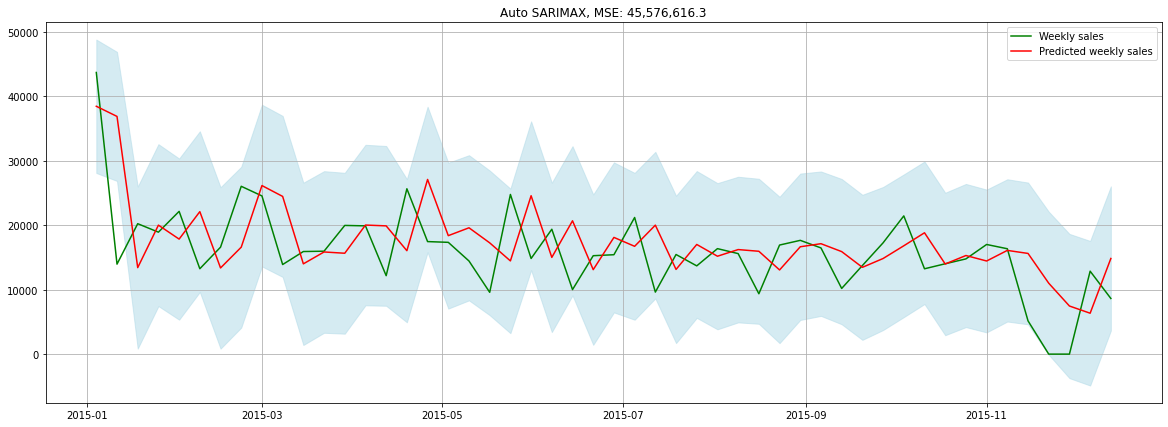

In [20]:
from tqdm.notebook import tqdm
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from dateutil.relativedelta import relativedelta
plt.rcParams["figure.figsize"] = (20,7)

#prepare exogenous variable
df_sarimax = df_data.copy()
df_sarimax['weekly_sales_rolling_std_3'] = df_sarimax.rolling(3).std().shift()
df_sarimax = df_sarimax.dropna()

# predict last 50 values one by one
pred_dict = {'date':[], 'pred_weekly_sales':[], 'ci_lower':[],'ci_upper':[] }

for i in tqdm(range(50)):
    
    # we will use directly weekly sales price without transforming
    training_data = df_sarimax['weekly_sales'][:(-50+i)]
    training_exo = df_sarimax['weekly_sales_rolling_std_3'][:(-50+i)].to_frame()
    
    model = auto_arima(training_data, X=training_exo)
    print('best model {}'.format(model.get_params()['order']), end = ' ')
    
    pred_date = training_data.index[-1] + relativedelta(weeks = 1)
    pred, confint = model.predict(X =df_sarimax[df_sarimax.index == pred_date]['weekly_sales_rolling_std_3'].to_frame(),
                                  n_periods=1, return_conf_int=True)
    
    pred_dict['date'].append(pred_date)
    pred_dict['pred_weekly_sales'].append(pred[0])
    pred_dict['ci_lower'].append(confint[0][0])
    pred_dict['ci_upper'].append(confint[0][1])
    

df_pred = pd.DataFrame(pred_dict)
df_pred = df_pred.set_index('date')
df_pred['weekly_sales'] = df_data['weekly_sales'][-50:]

plt.plot(df_pred['weekly_sales'], color = 'green')
plt.plot(df_pred['pred_weekly_sales'], color = 'red')
plt.legend(['Weekly sales', 'Predicted weekly sales'])
plt.fill_between(df_pred.index,
                 df_pred['ci_lower'],
                 df_pred['ci_upper'], color='lightblue', alpha=0.5)
plt.title('Auto SARIMAX, MSE: {:,}'.format(round(mean_squared_error(
    df_pred['weekly_sales'], df_pred['pred_weekly_sales']), 2)))
plt.grid()
plt.show()

<a id =topic16> </a>
# Vector Autoregression Model (VAR)

<div><span style="font-family: Arial;font-size:1.1em">Similar to the AR model but using multiple time series. As opposite to previous models which are utilizing univariate time series, where the signal has only a single time-dependent variable, the VAR model using <b>multivariate time series</b>. Basically, it means that each signal depends not only on its past but also on the previous values of some other signals. The simplest model VAR(1) with two time series $y_{t}$ and $x_{t}$ can be written as
$$y_{t} = \alpha_{1} + \beta_{11}y_{t-1} + \beta_{12}x_{t-1} + \epsilon_{y, t}$$
$$x_{t} = \alpha_{2} + \beta_{21}y_{t-1} + \beta_{22}x_{t-1} + \epsilon_{x, t}$$
where $\alpha$ and $\beta$ are coefficients, and $\epsilon$ is error.<br>
<a id =topic16.1> </a>
VAR model requires stationarity of signals. However, when signals $x_{t}$ and $y_{t}$ are I(1) (non-stationary with the order of integration 1) and if there is a $\theta$ such that $(y_{t} - \theta x_{t})$ is stationary, $x_{t}$ and $y_{t}$ are <b>cointegrated</b> and a VEC model can be used.<br>

<b>Cointegration</b> can be tested using augmented Engle-Granger cointegration test where the null hypothesis assumes that there is no cointegration. It means that if the p-value is less than 0.05, then we can reject a null hypothesis and say that signals are cointegrated. The example provided below.<span></div>

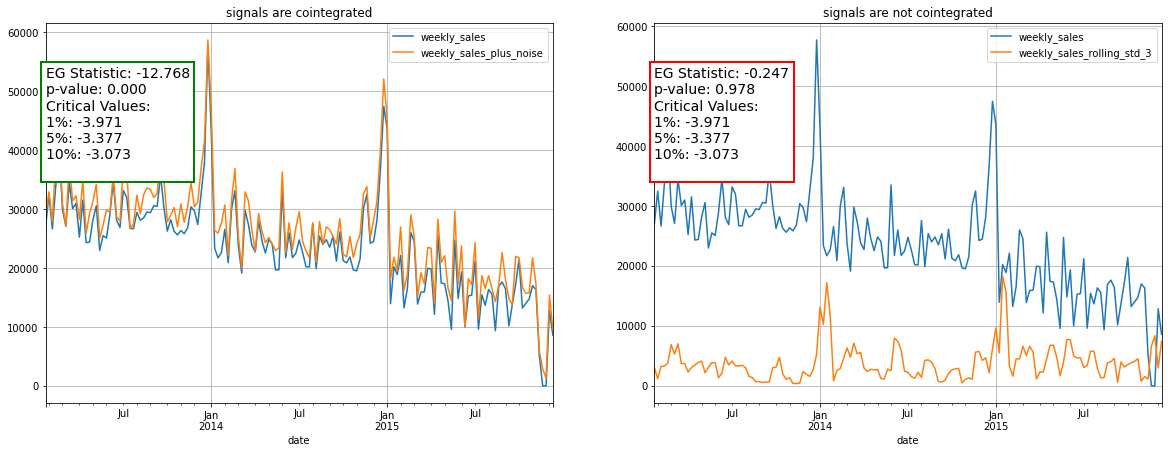

In [21]:
import statsmodels.tsa.stattools as ts

def eg_stat(s1, s2):
    """
    Test for no-cointegration of a univariate equation.

    The null hypothesis is no cointegration. Variables in y0 and y1 are assumed to be integrated 
    of order 1, I(1).

    This uses the augmented Engle-Granger two-step cointegration test.
    Constant or trend is included in 1st stage regression, i.e. in cointegrating equation. 
    
    Null hypothesis: Signal is non-stationary
    
    if EG Statistic p > critical values then we cannot reject null hypothesis (signals aren't cointegrated)
    if EG Statistic p < critical values then signals are cointegrated (based on significance)
    
    """
    result = ts.coint(s1, s2)
    s = ''
    s+= 'EG Statistic: %.3f\n' % result[0]
    s+= 'p-value: %.3f\n' % result[1]
    s+= 'Critical Values:\n'
    for key, value in zip(['1%', '5%', '10%'], result[2]):
        s += '%s: %.3f\n' % (key, value)
    
    if result[0] < result[2][0]:
        coint = 1
    elif result[2][0] <= result[0] and result[0] <= result[2][2]:
        coint = 2
    else:
        coint = 0
    
    return s, coint

def plot_eg_stat_test(s1,s2, ax):

    s1.plot(ax = ax, legend = s1.name)
    s2.plot(ax = ax, legend = s2.name)
    
    text_color_dict = {0:'red', 1: 'green', 2: 'yellow'}
    s, c_idx = eg_stat(s1, s2)
    
    ax.annotate(s, size=14, color='black', xy=(0.0, 0.6),xycoords='axes fraction',
                   bbox=dict(boxstyle="square,pad=0.3", fc="white", ec=text_color_dict[c_idx], lw=2))
    if c_idx == 0:
        ax.set_title('signals are not cointegrated')
    else:
        ax.set_title('signals are cointegrated')
    ax.grid()

plt.rcParams["figure.figsize"] = (20,7)
fig, axs = plt.subplots(1, 2)

df_coint = df_data.copy()
df_coint['weekly_sales_rolling_std_3'] = df_coint.rolling(3).std().shift()
df_coint['noise'] = [5000*np.random.rand() for x in range(len(df_coint))]
df_coint['weekly_sales_plus_noise'] = df_coint['weekly_sales']+df_coint['noise']
df_coint = df_coint.dropna()

plot_eg_stat_test(df_coint['weekly_sales'],df_coint['weekly_sales_plus_noise'], axs[0])
plot_eg_stat_test(df_coint['weekly_sales'],df_coint['weekly_sales_rolling_std_3'], axs[1])
plt.show()

<a id =topic17> </a>
# Vector Error Correction Model (VECM)

<div><span style="font-family: Arial;font-size:1.1em"> As explained in the previous section, if signals $x_{t}$ and $y_{t}$ are <b>cointegrated</b>, instead of VAR model, it is recommended to use VEC model.<br><br> 

Usually, using non-stationary time series in regression models can lead to a high $r^{2}$ value and statistically significant regression coefficients. These results are very likely misleading or spurious. It is because probably there is no real relationship between them and the only common thing is that they are growing (declining) over time. Everyone can test that by computing the correlation between two random walks.

Thus, from a simple regression $$y_{t} = \beta_{0} + \beta_{1}x_{t} + \epsilon_{t},$$ where both signals $x_{t}$ and $y_{t}$ are non-stationary, the error $\epsilon_{t}$ is also non-stationary as a linear combination of two non-stationary signals $$\epsilon_{t} = y_{t}-\beta_{0}-\beta_{1}x_{t}.$$

This violates some assumptions about errors in the model, as well as the assumption that $\epsilon_{t} \sim \mathcal{N}(1,0)$ (errors have a normal distribution with mean 0 and std 1).
<br><br>
However, if we found that $\epsilon_{t}$ is a stationary signal (using any stationarity test), then signals $y_{t}$ and $x_{t}$ are cointegrated and the regression mentioned above is not spurious. Also, it means that these signals have a long-run relationship between them.
<br><br>
Even if two series are cointegrated, it is still likely that $\epsilon_{t}$ will be serially correlated. To capture the serial correlation we can think of fitting the following specification $$y_{t} = \beta_{0} + \beta_{1}x_{t} + \alpha_{2}y_{t-1}+ \beta_{2}x_{t-1} + \epsilon_{t}$$ or however many lags are required. Also, we can rearrange this model to make sure that we have only stationary variables there. In the previous expression can be added $-y_{t-1}$ on both sides as well as $\beta_{1}x_{t-1} - \beta_{1}x_{t-1}$ on the right side. After rearranging, the formula will look like $$y_{t} - y_{t-1} = \beta_{0} + \beta_{1}(x_{t}-x_{t-1}) + (\alpha_{2}-1)y_{t-1}+ x_{t-1}(\beta_{1}+\beta_{2}) + \epsilon_{t}$$ or
$$\Delta y_{t} = \beta_{1}\Delta x_{t} + \psi(y_{t-1} - \pi_{1} -\pi_{2}x_{t-1}) + \epsilon_{t},$$
where $\psi = (\alpha_{2}-1)$, $\pi_{1} = \frac{\beta_{0}}{1-\alpha_{2}}$ and $\pi_{2} = \frac{\beta_{1}+\beta_{2}}{1-\alpha_{2}}$. This model is known as the error correction model. The term $\Delta x_{t}$ represents the model's short-run dynamics. The term $\psi(y_{t-1} - \pi_{1} -\pi_{2}x_{t-1})$ is known as the error-correction mechanism and $\psi$ is the error-correction parameter that measures how $y_{t}$ and $x_{t}$ react to deviations from long-run equilibrium. Also, notice that the expression $y_{t-1} - \pi_{1} -\pi_{2}x_{t-1}$ is basically the error from the model $y_{t-1} = \pi_{1} + \pi_{2}x_{t-1} + \epsilon_{t-1}.$
<br><br>
After all, the VECM from the simple VAR(1) model might look like
$$\Delta y_{t} = \alpha_{1} + \beta_{11}\Delta y_{t-1} + \beta_{12}\Delta x_{t-1} + \psi_{y}(y_{t-1} - \pi_{1} -\pi_{2}x_{t-1}) + \epsilon_{y, t}$$
$$\Delta x_{t} = \alpha_{2} + \beta_{21}\Delta y_{t-1} + \beta_{22}\Delta x_{t-1} + \psi_{x}(y_{t-1} - \pi_{1} -\pi_{2}x_{t-1}) +\epsilon_{x, t}.$$<span></div>

<a id =topic16.2> </a>
# VAR example

  0%|          | 0/50 [00:00<?, ?it/s]

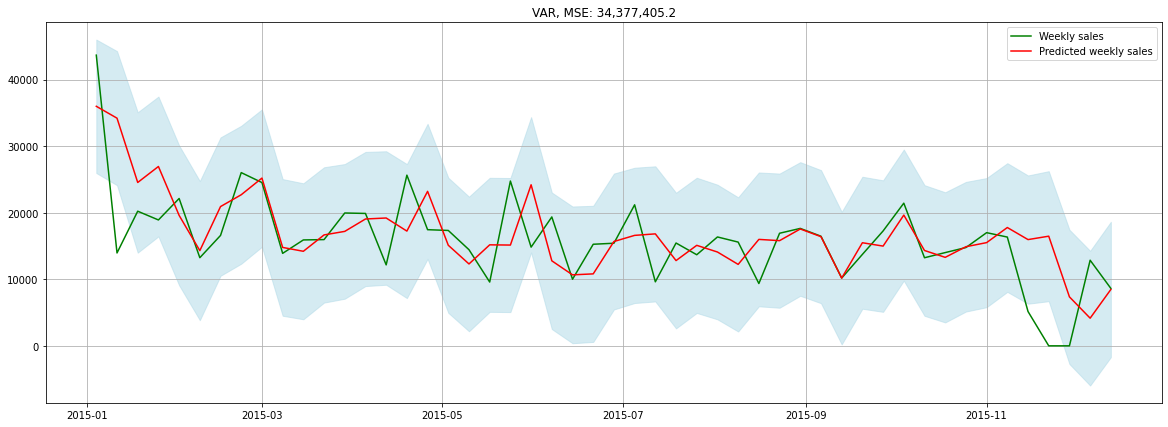

In [22]:
from statsmodels.tsa.api import VAR
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
from dateutil.relativedelta import relativedelta
plt.rcParams["figure.figsize"] = (20,7)

# Two stationary signals, weekly sales difference and standard deviation of the last 3 weekly sales, are used in VAR

df_var = df_data.copy()
df_var['weekly_sales_diff'] = df_var.diff()
df_var['weekly_sales_rolling_std_3'] = df_var['weekly_sales'].rolling(3).std()
df_var = df_var.dropna()

pred_dict = {'date':[], 'pred_diff':[], 'ci_lower':[],'ci_upper':[] }

for i in tqdm(range(50)):
    
    training_data = df_var[['weekly_sales_diff', 'weekly_sales_rolling_std_3']][:(-50+i)]
    
    # VAR model selects lag p based on AIC
    
    model = VAR(training_data)
    model_fit = model.fit(ic = 'aic')
    model_results = model_fit.forecast_interval(model_fit.y, steps=1)
    
    #model_results has this form 
    #     (array([[4.63470515e-02, 9.85550752e+02]]),
    #      array([[ -0.19744317, 173.58328614]]),
    #      array([[2.90137274e-01, 1.79751822e+03]]))
    
    pred_date = training_data.index[-1] + relativedelta(weeks = 1)
    
    pred_dict['date'].append(pred_date)
    pred_dict['pred_diff'].append(model_results[0][0][0])
    pred_dict['ci_lower'].append(model_results[1][0][0])
    pred_dict['ci_upper'].append(model_results[2][0][0])
    
    
# transform data
df_pred = pd.DataFrame(pred_dict)
df_pred = df_pred.set_index('date')
df_pred['weekly_sales_diff'] = df_var['weekly_sales_diff'][-50:]


#df_pred = pd.merge(df_pred, df_var, how = 'left', left_index = True, right_index = True)
df_pred['pred_weekly_sales'] = df_pred['pred_diff'] + df_var['weekly_sales'].shift()
df_pred['weekly_sales'] = df_pred['weekly_sales_diff'] + df_var['weekly_sales'].shift()
df_pred['ci_lower'] = df_pred['ci_lower'] + df_var['weekly_sales'].shift()
df_pred['ci_upper'] = df_pred['ci_upper'] + df_var['weekly_sales'].shift()

plt.plot(df_pred['weekly_sales'], color = 'green')
plt.plot(df_pred['pred_weekly_sales'], color = 'red')
plt.legend(['Weekly sales', 'Predicted weekly sales'])
plt.fill_between(df_pred.index,
                 df_pred['ci_lower'],
                 df_pred['ci_upper'], color='lightblue', alpha=0.5)
plt.title('VAR, MSE: {:,}'.format(round(mean_squared_error(
    df_pred['weekly_sales'], df_pred['pred_weekly_sales']), 2)))
plt.grid()
plt.show()

<a id =topic16.3> </a>
# VECM example

  0%|          | 0/50 [00:00<?, ?it/s]

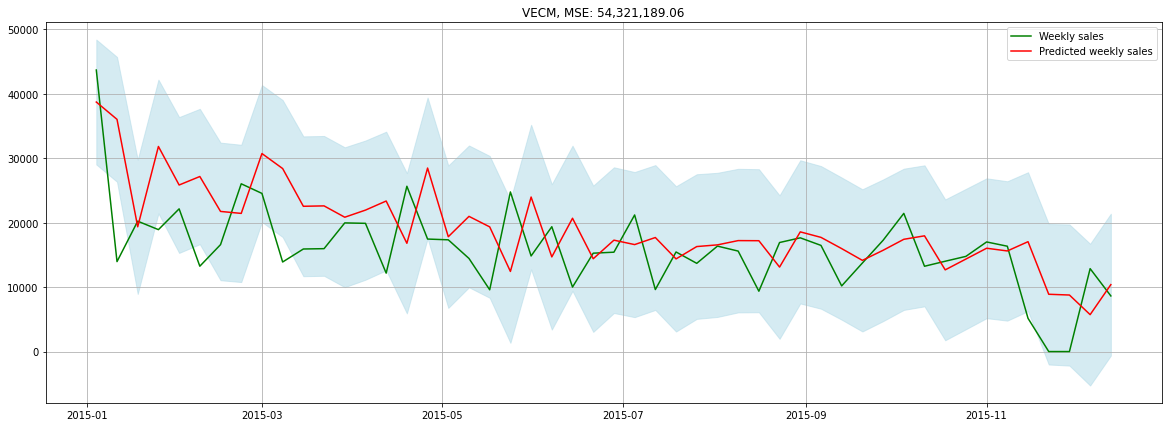

In [23]:
from statsmodels.tsa.api import VECM
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
from dateutil.relativedelta import relativedelta
plt.rcParams["figure.figsize"] = (20,7)

# Cointegrated signals weekly sales and weekly sales plus noise

df_vecm = df_data.copy()
df_vecm['noise'] = [5000*np.random.rand() for x in range(len(df_vecm))]
df_vecm['weekly_sales_plus_noise'] = df_vecm['weekly_sales']+df_vecm['noise']

pred_dict = {'date':[], 'pred_weekly_sales':[], 'ci_lower':[],'ci_upper':[] }

for i in tqdm(range(50)):
    
    training_data = df_vecm[['weekly_sales', 'weekly_sales_plus_noise']][:(-50+i)]
    
    # VECM model, k_ar_diff - number of lagged differences in the model
    
    model = VECM(training_data, coint_rank = 1, k_ar_diff=5)

    model_fit = model.fit()
    pred, lower, upper = model_fit.predict(steps = 1, alpha = 0.05)
    
    pred_date = training_data.index[-1] + relativedelta(weeks = 1)
    
    pred_dict['date'].append(pred_date)
    pred_dict['pred_weekly_sales'].append(pred[0][0])
    pred_dict['ci_lower'].append(lower[0][0])
    pred_dict['ci_upper'].append(upper[0][0])
    
df_pred = pd.DataFrame(pred_dict)
df_pred = df_pred.set_index('date')
df_pred['weekly_sales'] = df_vecm['weekly_sales'][-50:]

plt.plot(df_pred['weekly_sales'], color = 'green')
plt.plot(df_pred['pred_weekly_sales'], color = 'red')
plt.legend(['Weekly sales', 'Predicted weekly sales'])
plt.fill_between(df_pred.index,
                 df_pred['ci_lower'],
                 df_pred['ci_upper'], color='lightblue', alpha=0.5)
plt.title('VECM, MSE: {:,}'.format(round(mean_squared_error(
    df_pred['weekly_sales'], df_pred['pred_weekly_sales']), 2)))
plt.grid()
plt.show()

<a id =topic18> </a>
# Vector Autoregression Moving Average Model (VARMA)

<div><span style="font-family: Arial;font-size:1.1em">  This model is a combination of VAR and MA models. The simplest form VARMA(1, 1) is formulated as
$$y_{t} = \alpha_{1} + \beta_{11}y_{t-1} + \beta_{12}x_{t-1} + \epsilon_{y, t}+\gamma_{11} \epsilon_{y, t-1}$$
$$x_{t} = \alpha_{2} + \beta_{21}y_{t-1} + \beta_{22}x_{t-1} + \epsilon_{x, t}+\gamma_{21} \epsilon_{x, t-1},$$
where $\alpha, \beta$ and $\gamma$ are coefficients, and $\epsilon$ error.<br>
VARMA requires stationarity.<span></div>

  0%|          | 0/50 [00:00<?, ?it/s]

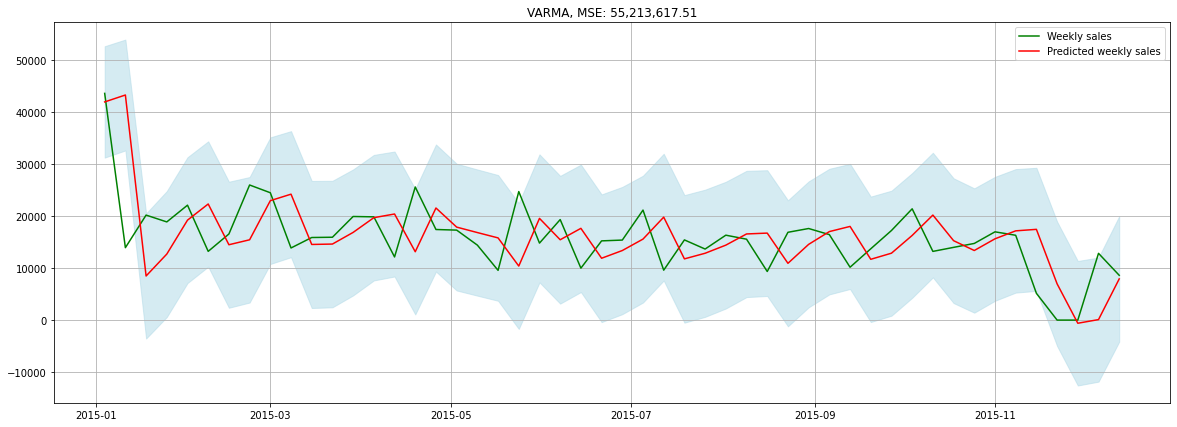

In [24]:
from statsmodels.tsa.api import VARMAX
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
from dateutil.relativedelta import relativedelta
plt.rcParams["figure.figsize"] = (20,7)

# Two stationary signals, weekly sales difference and standard deviation of the last 3 weekly sales, are used in VARMA

df_varma = df_data.copy()
df_varma['weekly_sales_diff'] = df_varma.diff()
df_varma['weekly_sales_rolling_std_3'] = df_varma['weekly_sales'].rolling(3).std()
df_varma = df_varma.dropna()

# predict last 50 values one by one
df_pred = pd.DataFrame()

for i in tqdm(range(50)):
    
    training_data = df_varma[['weekly_sales_diff', 'weekly_sales_rolling_std_3']][:(-50+i)]
    
    # VARMA model selects lag p based on AIC
    
    model = VARMAX(training_data)
    model_fit = model.fit(ic = 'aic')
    model_forecast = model_fit.get_forecast(steps = 1)
    
    df_pred_temp = pd.concat([model_forecast.conf_int(),
                              model_forecast.predicted_mean], axis = 1)
    
    df_pred_temp = df_pred_temp[['lower weekly_sales_diff', 'upper weekly_sales_diff', 'weekly_sales_diff']]
    
    df_pred = df_pred.append(df_pred_temp)
    
df_pred = df_pred.rename(columns = {'lower weekly_sales_diff': 'ci_lower', 
                                   'upper weekly_sales_diff': 'ci_upper',
                                   'weekly_sales_diff':'pred_weekly_sales_diff'})

df_pred['weekly_sales_diff'] = df_varma['weekly_sales_diff'][-50:]

# transform data
df_pred['pred_weekly_sales'] = df_pred['pred_weekly_sales_diff'] + df_varma['weekly_sales'].shift()
df_pred['weekly_sales'] = df_pred['weekly_sales_diff'] + df_varma['weekly_sales'].shift()
df_pred['ci_lower'] = df_pred['ci_lower'] + df_varma['weekly_sales'].shift()
df_pred['ci_upper'] = df_pred['ci_upper'] + df_varma['weekly_sales'].shift()

plt.plot(df_pred['weekly_sales'], color = 'green')
plt.plot(df_pred['pred_weekly_sales'], color = 'red')
plt.legend(['Weekly sales', 'Predicted weekly sales'])
plt.fill_between(df_pred.index,
                 df_pred['ci_lower'],
                 df_pred['ci_upper'], color='lightblue', alpha=0.5)
plt.title('VARMA, MSE: {:,}'.format(round(mean_squared_error(
    df_pred['weekly_sales'], df_pred['pred_weekly_sales']), 2)))
plt.grid()
plt.show()

<a id =topic18> </a>
# Vector Autoregression Moving Average with Exogenous Regressors Model (VARMAX)

<div><span style="font-family: Arial;font-size:1.1em">VARMAX is VARMA model with exogenous variables, also called covariates. Exogenous variables represent additional factors or input features for the model, which have observations at the same time steps as the forecasted series. It means that for forecasting $y_{t+1}$, the exogenous input should have the same time-step, i.e. $x_{t+1}$. The simplest model VARMAX(1, 1) with one exogenous variable $z_{t}$ can be written as

$$y_{t} = \alpha_{1} + \beta_{11}y_{t-1} + \beta_{12}x_{t-1} +\delta_{11}z_{t} + \epsilon_{y, t}+\gamma_{11} \epsilon_{y, t-1}$$
$$x_{t} = \alpha_{2} + \beta_{21}y_{t-1} + \beta_{22}x_{t-1} +\delta_{21}z_{t} + \epsilon_{x, t}+\gamma_{21} \epsilon_{x, t-1},$$

where $\alpha, \beta, \gamma$ and $\delta$ are coefficients and $\epsilon$ $\sim$ $\mathcal{N}$$(0,\Omega)$  are errors.

VARMAX requires stationarity.<span></div>

  0%|          | 0/50 [00:00<?, ?it/s]

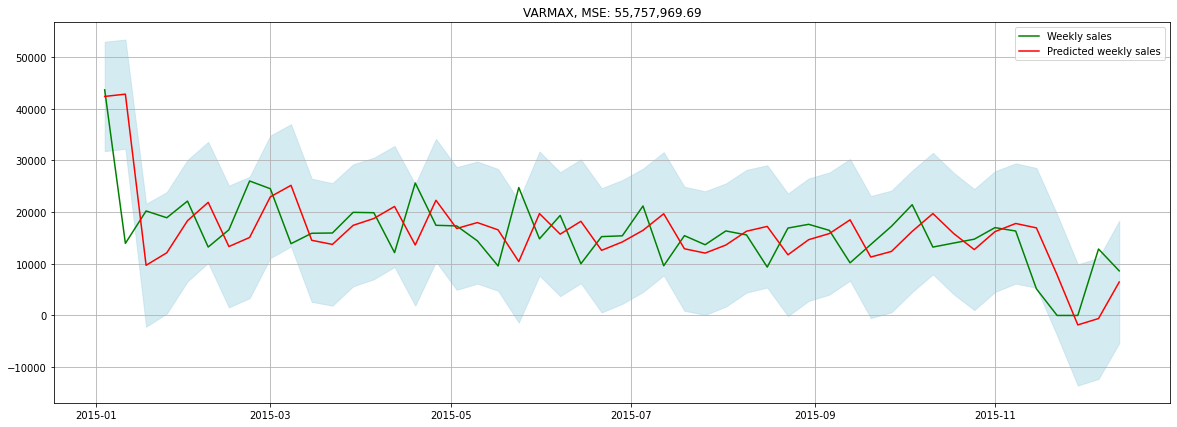

In [25]:
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
from dateutil.relativedelta import relativedelta
plt.rcParams["figure.figsize"] = (20,7)

# Construct two stationary signals
df_varmax = df_data.copy()
df_varmax['weekly_sales_diff'] = df_varmax.diff()
df_varmax['weekly_sales_rolling_std_3'] = df_varmax['weekly_sales'].rolling(3).std()
df_varmax = df_varmax.dropna()
#prepare exogenous variable
exo_df = df_varmax['weekly_sales_diff'].to_frame()
exo_df['noise'] = [5000*np.random.rand() for x in range(len(exo_df))]
exo_df['weekly_sales_diff_plus_noise'] = exo_df['weekly_sales_diff']+exo_df['noise']
exo_df['weekly_sales_diff_plus_noise'] = exo_df['weekly_sales_diff_plus_noise'].shift().fillna(0)

#predict last 50 values one by one
df_pred = pd.DataFrame()

for i in tqdm(range(50)):
    
    training_data = df_varmax[['weekly_sales_diff', 'weekly_sales_rolling_std_3']][:(-50+i)]
    training_exo = exo_df[exo_df.index.isin(training_data.index)]['weekly_sales_diff_plus_noise'].to_frame()
    
    # VARMAX model selects lag p based on AIC
    
    model = VARMAX(training_data, exog=training_exo)
    model_fit = model.fit(ic = 'aic')
    
    pred_date = training_data.index[-1] + relativedelta(weeks = 1)
    model_forecast = model_fit.get_forecast(steps = 1, exog =exo_df[exo_df.index == pred_date]['weekly_sales_diff_plus_noise'].to_frame())
    
    df_pred_temp = pd.concat([model_forecast.conf_int(),
                              model_forecast.predicted_mean], axis = 1)
    
    df_pred_temp = df_pred_temp[['lower weekly_sales_diff', 'upper weekly_sales_diff', 'weekly_sales_diff']]
    
    df_pred = df_pred.append(df_pred_temp)
    
df_pred = df_pred.rename(columns = {'lower weekly_sales_diff': 'ci_lower', 
                                   'upper weekly_sales_diff': 'ci_upper',
                                   'weekly_sales_diff':'pred_weekly_sales_diff'})

df_pred['weekly_sales_diff'] = df_varmax['weekly_sales_diff'][-50:]

# transform data
df_pred['pred_weekly_sales'] = df_pred['pred_weekly_sales_diff'] + df_varmax['weekly_sales'].shift()
df_pred['weekly_sales'] = df_pred['weekly_sales_diff'] + df_varmax['weekly_sales'].shift()
df_pred['ci_lower'] = df_pred['ci_lower'] + df_varmax['weekly_sales'].shift()
df_pred['ci_upper'] = df_pred['ci_upper'] + df_varmax['weekly_sales'].shift()

plt.plot(df_pred['weekly_sales'], color = 'green')
plt.plot(df_pred['pred_weekly_sales'], color = 'red')
plt.legend(['Weekly sales', 'Predicted weekly sales'])
plt.fill_between(df_pred.index,
                 df_pred['ci_lower'],
                 df_pred['ci_upper'], color='lightblue', alpha=0.5)
plt.title('VARMAX, MSE: {:,}'.format(round(mean_squared_error(
    df_pred['weekly_sales'], df_pred['pred_weekly_sales']), 2)))
plt.grid()
plt.show()

## References:
* Rob J Hyndman and George Athanasopoulos, Forecasting: Principles & Practice, https://otexts.com/fpp2/
* ritvikmath, https://www.youtube.com/channel/UCUcpVoi5KkJmnE3bvEhHR0Q
* Statistics How To, https://www.statisticshowto.com/
* https://stats.stackexchange.com/questions/281666/how-does-acf-pacf-identify-the-order-of-ma-and-ar-terms
* https://stats.stackexchange.com/questions/394796/should-my-time-series-be-stationary-to-use-arima-model
* auto_arima documentation, https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
* https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html
* Rob J Hyndman, The ARIMAX model muddle, https://robjhyndman.com/hyndsight/arimax/
* Jeffrey A. Parker, Vector Autoregression and Vector Error-Correction Models, https://www.reed.edu/economics/parker/s14/312/tschapters/S13_Ch_5.pdf
* Hany Abdel-Latif, Lecture 5: VAR and VEC Models, https://www.youtube.com/watch?v=XK3cEJw93jA
* https://stats.stackexchange.com/questions/148994/var-or-vecm-for-a-mix-of-stationary-and-nonstationary-variables
* Econometrics with R, Cointegration, https://www.econometrics-with-r.org/16-3-cointegration.html
* Yury Kashnitsky, Topic 9. Part 1. Time series analysis in Python, https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python
* Wikipedia, Exponential smoothing, https://en.wikipedia.org/wiki/Exponential_smoothing
* Jason Brownlee, How to Decompose Time Series Data into Trend and Seasonality, https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
* Galit Shmueli, Smoothing 5: Holt's exponential smoothing, https://www.youtube.com/watch?v=DUyZl-abnNM
* Galit Shmueli, Smoothing 6: Winter's exponential smoothing, https://www.youtube.com/watch?v=mrLiC1biciY